In [7]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import sys

In [258]:
def encode_lable(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt

In [259]:
def sigm(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [261]:
def sigm_derivative(theta, X):
    return h(theta, X) * (1 - h(theta, X))

In [262]:
def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)

In [263]:
def CEderivative(X, y_gt, y_pred):
    return np.dot(y_pred - y_gt, X) / len(y_gt)

In [264]:
def acc(y_test, y_out):
    accuracy = 0
    for i in range(len(y_out)):
        if np.argmax(y_test[i]) == np.argmax(y_out[i]):
            accuracy += 1
    return accuracy / len(y_test)

In [265]:
def RMSprob(Et_1, g, gamma, mu, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    delta = (mu)/np.sqrt(Et + e)
    delta*=g
    return delta 

In [289]:
def forward(thetas, X, dropout_prob, train_test_check):
    num_layers = thetas.shape[0]
    outs = []
    for t in range(0, num_layers): #проходим по всем слоям (все слои с сигмоидальной функцией активации)
        if t == 0:
            outs.append(np.array([h(thetas[t][:, i], X) for i in range(0, thetas[t].shape[1])]).T)
        else:
            outs.append(np.array([h(thetas[t][:, i], np.asarray(outs[t-1])) for i in range(0, thetas[t].shape[1])]).T)
    #Dropout
    if train_test_check:
        for i in range(len(outs) - 1):#для всех слоев кроме выходного и входного
            for o in outs[i]:
                o *= np.random.binomial(1,dropout_prob,o.shape[0]) * (1) / (1 - dropout_prob)
    return [out for out in outs]

In [267]:
def backward(X, y_gt, thetas, dropout_prob):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    outs = forward(thetas, X,dropout_prob, True)
    num_layers = len(outs)
    d_theta = []
    d_theta.append(np.zeros([num_features, outs[0].shape[1]]))
    for i in range(0, num_layers - 1):
        d_theta.append(np.zeros([outs[i].shape[1], outs[i+1].shape[1]]))
    tmp_th = None
    #скрытые слои
    for i in range(len(outs) - 1, -1, -1):
        if i == len(outs) - 1:#выходной слой
            for class_no in range(0, num_classes):
                d_theta[i][:, class_no] = CEderivative(outs[i-1], y_gt[:, class_no], outs[i][:, class_no])
            tmp_th = outs[i] - y_gt
        elif i == 0:#первый скрытый
            tmp_th = np.dot(tmp_th, thetas[1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[0], X)
            d_theta[0] = np.dot(X.T, tmp_th)
            d_theta[0] = d_theta[0]/outs[0].shape[0]
        else:# остальные скрытые
            tmp_th = np.dot(tmp_th, thetas[i+1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[i], outs[i-1])
            d_theta[i] = np.dot(outs[i-1].T, tmp_th)
            d_theta[i] = d_theta[i]/outs[i].shape[0]
    return d_theta

In [90]:
(dx_train, dy_train), (x_test, y_test) = cifar10.load_data()

In [91]:
print('x_train shape:', dx_train.shape)
print(dx_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [92]:
dy_train = encode_lable(dy_train, 10)
y_test = encode_lable(y_test, 10)

In [93]:
dx_train = np.asarray([list(x.flat) for x in dx_train])
x_test = np.asarray([list(x.flat) for x in x_test])

In [94]:
p = np.random.permutation(dx_train.shape[0])
x_train = dx_train[p[0:int(len(dx_train)*0.8)], :]
y_train = dy_train[p[0:int(len(dx_train)*0.8)]]
x_val = dx_train[p[int(len(dx_train)*0.8):], :]
y_val = dy_train[p[int(len(dx_train)*0.8):]]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 3072)
y_train shape: (40000, 10)
x_val shape: (10000, 3072)
y_val shape: (10000, 10)
x_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [95]:
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_val = (x_val - np.mean(x_val, axis = 0)) / np.var(x_val, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

Initial loss : 19.321031403726042


Epoch 0/2000 ...........
Loss train: 3.195827433849215 
Loss val: 3.2047934425333358 
Train accuracy :  0.1453 
Validation accuracy :  0.1411
Alpha:  4


Epoch 1/2000 ...........
Loss train: 3.2271198366712612 
Loss val: 3.253757307923412 
Train accuracy :  0.1961 
Validation accuracy :  0.1805
Alpha:  3.98


Epoch 2/2000 ...........
Loss train: 3.059425646154743 
Loss val: 3.078950447894799 
Train accuracy :  0.23155 
Validation accuracy :  0.2189
Alpha:  3.9601


Epoch 3/2000 ...........
Loss train: 3.071305495704197 
Loss val: 3.0966809912858495 
Train accuracy :  0.251825 
Validation accuracy :  0.2421
Alpha:  3.9402995


Epoch 4/2000 ...........
Loss train: 3.038201795895154 
Loss val: 3.053774937630151 
Train accuracy :  0.26125 
Validation accuracy :  0.2557
Alpha:  3.9205980025000002


Epoch 5/2000 ...........
Loss train: 2.8791943549904477 
Loss val: 2.898221231921188 
Train accuracy :  0.287125 
Validation accuracy :  0.2785
Alpha:  3.90099

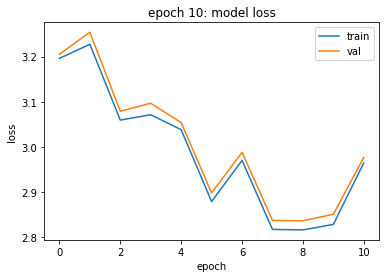

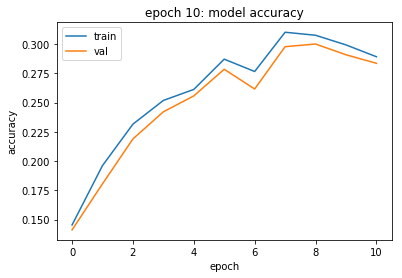



Epoch 11/2000 ...........
Loss train: 2.9647556842184524 
Loss val: 2.9919281426180397 
Train accuracy :  0.2954 
Validation accuracy :  0.2919
Alpha:  3.785418319253772


Epoch 12/2000 ...........
Loss train: 2.88657418592635 
Loss val: 2.9098412874360196 
Train accuracy :  0.303525 
Validation accuracy :  0.2994
Alpha:  3.766491227657503


Epoch 13/2000 ...........
Loss train: 2.8282663035281255 
Loss val: 2.851314285937208 
Train accuracy :  0.312675 
Validation accuracy :  0.3024
Alpha:  3.7476587715192156


Epoch 14/2000 ...........
Loss train: 2.8372577598967905 
Loss val: 2.8787936173495656 
Train accuracy :  0.32305 
Validation accuracy :  0.3121
Alpha:  3.7289204776616196


Epoch 15/2000 ...........
Loss train: 2.7380675235254253 
Loss val: 2.774527444286939 
Train accuracy :  0.3424 
Validation accuracy :  0.3332
Alpha:  3.7102758752733114


Epoch 16/2000 ...........
Loss train: 2.728866701220519 
Loss val: 2.7628634645149583 
Train accuracy :  0.342375 
Validation accuracy

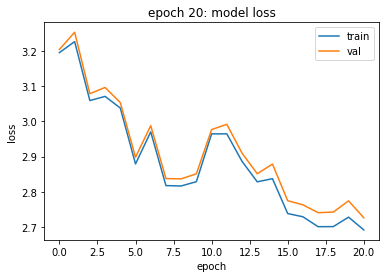

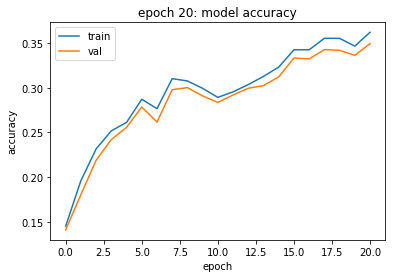



Epoch 21/2000 ...........
Loss train: 2.6737295882209104 
Loss val: 2.710787450452081 
Train accuracy :  0.36315 
Validation accuracy :  0.3533
Alpha:  3.600349711492978


Epoch 22/2000 ...........
Loss train: 2.679260078515437 
Loss val: 2.7260554195150615 
Train accuracy :  0.366575 
Validation accuracy :  0.3551
Alpha:  3.582347962935513


Epoch 23/2000 ...........
Loss train: 2.6731601373151044 
Loss val: 2.70864961512218 
Train accuracy :  0.365925 
Validation accuracy :  0.3535
Alpha:  3.5644362231208353


Epoch 24/2000 ...........
Loss train: 2.688473148203146 
Loss val: 2.7354477959871226 
Train accuracy :  0.360025 
Validation accuracy :  0.3472
Alpha:  3.5466140420052312


Epoch 25/2000 ...........
Loss train: 2.6552119118349378 
Loss val: 2.6940404384490155 
Train accuracy :  0.370175 
Validation accuracy :  0.3558
Alpha:  3.528880971795205


Epoch 26/2000 ...........
Loss train: 2.6598061754950004 
Loss val: 2.7019307547705465 
Train accuracy :  0.367375 
Validation accur

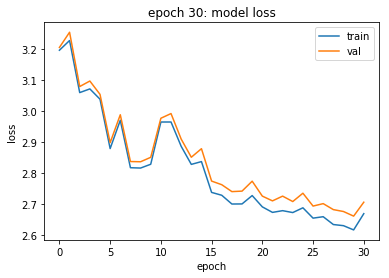

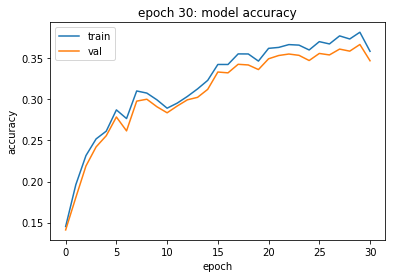



Epoch 31/2000 ...........
Loss train: 2.646092705493467 
Loss val: 2.6865187883752704 
Train accuracy :  0.368675 
Validation accuracy :  0.3574
Alpha:  3.4243290838204907


Epoch 32/2000 ...........
Loss train: 2.607904876678142 
Loss val: 2.6528834820553504 
Train accuracy :  0.383125 
Validation accuracy :  0.3698
Alpha:  3.407207438401388


Epoch 33/2000 ...........
Loss train: 2.609821864360377 
Loss val: 2.657324231393725 
Train accuracy :  0.38265 
Validation accuracy :  0.3681
Alpha:  3.3901714012093813


Epoch 34/2000 ...........
Loss train: 2.6051110214008477 
Loss val: 2.6542062436857323 
Train accuracy :  0.38165 
Validation accuracy :  0.3667
Alpha:  3.3732205442033343


Epoch 35/2000 ...........
Loss train: 2.6051321403703573 
Loss val: 2.6485864608598906 
Train accuracy :  0.3772 
Validation accuracy :  0.3674
Alpha:  3.3563544414823174


Epoch 36/2000 ...........
Loss train: 2.610367842481954 
Loss val: 2.6634563790347996 
Train accuracy :  0.38025 
Validation accurac

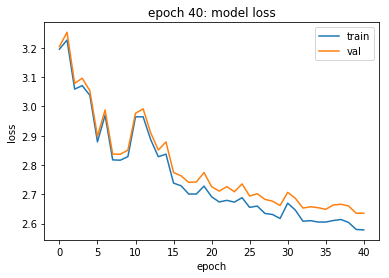

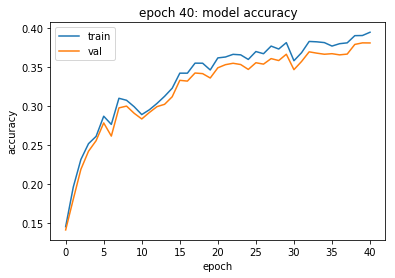



Epoch 41/2000 ...........
Loss train: 2.5885831440287035 
Loss val: 2.646244146800872 
Train accuracy :  0.394575 
Validation accuracy :  0.3814
Alpha:  3.2569140816702435


Epoch 42/2000 ...........
Loss train: 2.6060593390677096 
Loss val: 2.656323931272593 
Train accuracy :  0.384775 
Validation accuracy :  0.369
Alpha:  3.240629511261892


Epoch 43/2000 ...........
Loss train: 2.5712329908272498 
Loss val: 2.6235399784570452 
Train accuracy :  0.3952 
Validation accuracy :  0.384
Alpha:  3.2244263637055828


Epoch 44/2000 ...........
Loss train: 2.5713946997738137 
Loss val: 2.6296102587795365 
Train accuracy :  0.39935 
Validation accuracy :  0.3847
Alpha:  3.208304231887055


Epoch 45/2000 ...........
Loss train: 2.5687528670480866 
Loss val: 2.625810056568604 
Train accuracy :  0.3959 
Validation accuracy :  0.3839
Alpha:  3.19226271072762


Epoch 46/2000 ...........
Loss train: 2.5708579964088765 
Loss val: 2.6331520578832137 
Train accuracy :  0.401925 
Validation accuracy :

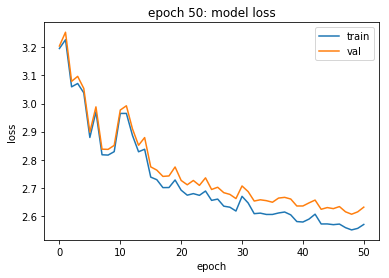

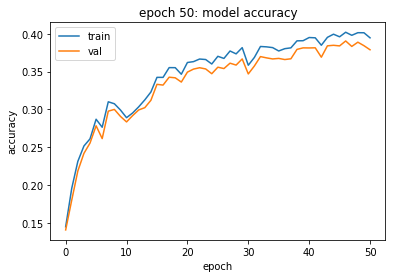



Epoch 51/2000 ...........
Loss train: 2.554973701015619 
Loss val: 2.6132179888874676 
Train accuracy :  0.397625 
Validation accuracy :  0.3839
Alpha:  3.097683977133195


Epoch 52/2000 ...........
Loss train: 2.544486142007864 
Loss val: 2.6026675460592785 
Train accuracy :  0.404775 
Validation accuracy :  0.3909
Alpha:  3.082195557247529


Epoch 53/2000 ...........
Loss train: 2.571290849104415 
Loss val: 2.6269738322719567 
Train accuracy :  0.394025 
Validation accuracy :  0.3804
Alpha:  3.0667845794612916


Epoch 54/2000 ...........
Loss train: 2.549094440240648 
Loss val: 2.608530770707188 
Train accuracy :  0.406025 
Validation accuracy :  0.3913
Alpha:  3.051450656563985


Epoch 55/2000 ...........
Loss train: 2.5431834548348635 
Loss val: 2.606386917491052 
Train accuracy :  0.41025 
Validation accuracy :  0.3901
Alpha:  3.036193403281165


Epoch 56/2000 ...........
Loss train: 2.5400987663865866 
Loss val: 2.595524366699483 
Train accuracy :  0.40615 
Validation accuracy 

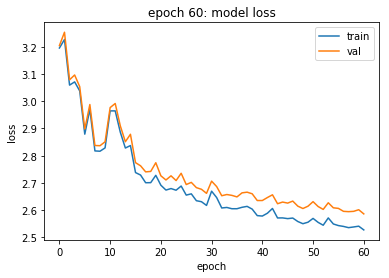

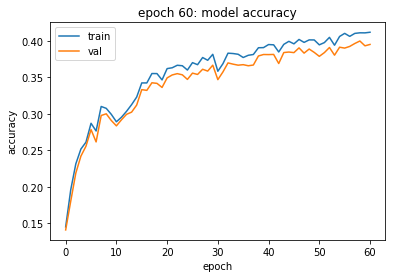



Epoch 61/2000 ...........
Loss train: 2.5279117034099636 
Loss val: 2.590446243389848 
Train accuracy :  0.412375 
Validation accuracy :  0.3962
Alpha:  2.946238611632884


Epoch 62/2000 ...........
Loss train: 2.5485739980205464 
Loss val: 2.605475143608271 
Train accuracy :  0.404975 
Validation accuracy :  0.3873
Alpha:  2.9315074185747196


Epoch 63/2000 ...........
Loss train: 2.53397845259068 
Loss val: 2.5918722753265513 
Train accuracy :  0.4086 
Validation accuracy :  0.3899
Alpha:  2.916849881481846


Epoch 64/2000 ...........
Loss train: 2.526669247112791 
Loss val: 2.5853849765630548 
Train accuracy :  0.410525 
Validation accuracy :  0.3959
Alpha:  2.902265632074437


Epoch 65/2000 ...........
Loss train: 2.524641783903823 
Loss val: 2.58696249442076 
Train accuracy :  0.41525 
Validation accuracy :  0.3987
Alpha:  2.8877543039140647


Epoch 66/2000 ...........
Loss train: 2.5226204187806625 
Loss val: 2.584846393967389 
Train accuracy :  0.408675 
Validation accuracy : 

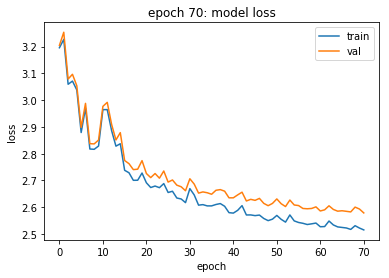

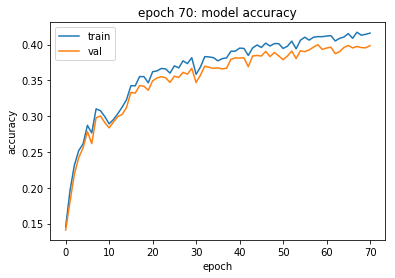



Epoch 71/2000 ...........
Loss train: 2.5228837929018764 
Loss val: 2.588016920003944 
Train accuracy :  0.40895 
Validation accuracy :  0.3931
Alpha:  2.802197390293447


Epoch 72/2000 ...........
Loss train: 2.5060118922624466 
Loss val: 2.571729865584826 
Train accuracy :  0.418875 
Validation accuracy :  0.4046
Alpha:  2.78818640334198


Epoch 73/2000 ...........
Loss train: 2.510124332061442 
Loss val: 2.5792468068802195 
Train accuracy :  0.41605 
Validation accuracy :  0.3959
Alpha:  2.77424547132527


Epoch 74/2000 ...........
Loss train: 2.5061420464589195 
Loss val: 2.5711591601086408 
Train accuracy :  0.4202 
Validation accuracy :  0.4035
Alpha:  2.7603742439686436


Epoch 75/2000 ...........
Loss train: 2.5134242127507695 
Loss val: 2.57949187428673 
Train accuracy :  0.42045 
Validation accuracy :  0.4011
Alpha:  2.7465723727488003


Epoch 76/2000 ...........
Loss train: 2.5142071021870467 
Loss val: 2.5824457385502333 
Train accuracy :  0.414175 
Validation accuracy : 

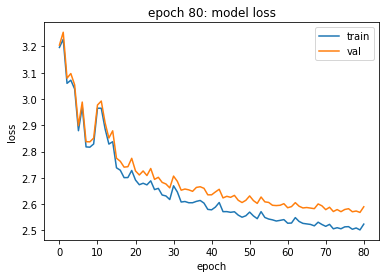

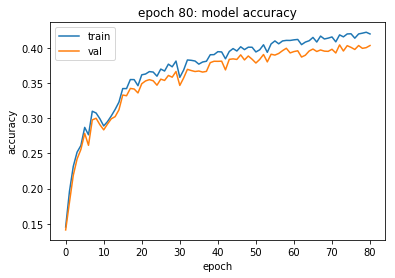



Epoch 81/2000 ...........
Loss train: 2.5042942379729736 
Loss val: 2.5735485376333176 
Train accuracy :  0.42325 
Validation accuracy :  0.4032
Alpha:  2.665198325472846


Epoch 82/2000 ...........
Loss train: 2.504970104162111 
Loss val: 2.5718802367571234 
Train accuracy :  0.42375 
Validation accuracy :  0.4047
Alpha:  2.651872333845482


Epoch 83/2000 ...........
Loss train: 2.499315117004732 
Loss val: 2.5664832523165186 
Train accuracy :  0.421675 
Validation accuracy :  0.4051
Alpha:  2.6386129721762543


Epoch 84/2000 ...........
Loss train: 2.4943472217625406 
Loss val: 2.568748801695264 
Train accuracy :  0.425875 
Validation accuracy :  0.4053
Alpha:  2.625419907315373


Epoch 85/2000 ...........
Loss train: 2.4949575630636747 
Loss val: 2.5644291763281584 
Train accuracy :  0.424175 
Validation accuracy :  0.4023
Alpha:  2.612292807778796


Epoch 86/2000 ...........
Loss train: 2.4856686558628915 
Loss val: 2.557415104185688 
Train accuracy :  0.426025 
Validation accura

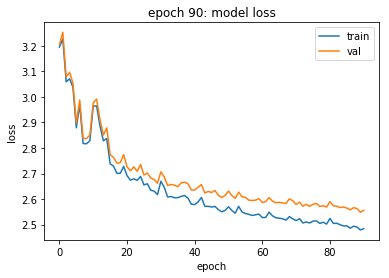

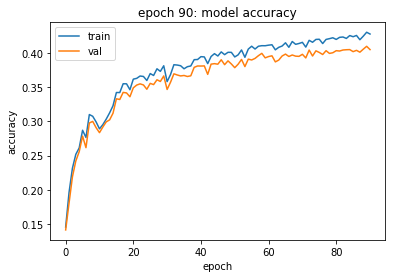



Epoch 91/2000 ...........
Loss train: 2.486341482813558 
Loss val: 2.558432352824905 
Train accuracy :  0.426675 
Validation accuracy :  0.4094
Alpha:  2.5348971270576346


Epoch 92/2000 ...........
Loss train: 2.4868123163207807 
Loss val: 2.5579384411530244 
Train accuracy :  0.42825 
Validation accuracy :  0.4069
Alpha:  2.5222226414223465


Epoch 93/2000 ...........
Loss train: 2.4946368821286824 
Loss val: 2.566107996268131 
Train accuracy :  0.419725 
Validation accuracy :  0.4021
Alpha:  2.5096115282152347


Epoch 94/2000 ...........
Loss train: 2.4892738596976756 
Loss val: 2.5645538106641332 
Train accuracy :  0.428 
Validation accuracy :  0.4052
Alpha:  2.4970634705741586


Epoch 95/2000 ...........
Loss train: 2.4900350583805113 
Loss val: 2.5635548947653235 
Train accuracy :  0.4279 
Validation accuracy :  0.407
Alpha:  2.4845781532212876


Epoch 96/2000 ...........
Loss train: 2.488504899147141 
Loss val: 2.561733801492538 
Train accuracy :  0.42675 
Validation accuracy 

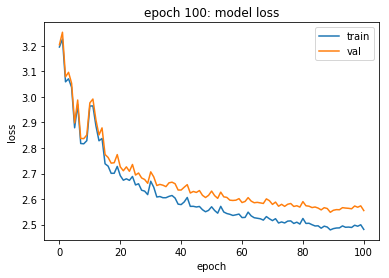

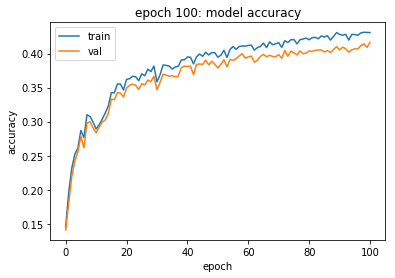



Epoch 101/2000 ...........
Loss train: 2.489927493410624 
Loss val: 2.5656251216838837 
Train accuracy :  0.427475 
Validation accuracy :  0.4074
Alpha:  2.4109663372330967


Epoch 102/2000 ...........
Loss train: 2.4868256224749534 
Loss val: 2.560860025744658 
Train accuracy :  0.43055 
Validation accuracy :  0.4132
Alpha:  2.3989115055469314


Epoch 103/2000 ...........
Loss train: 2.47690608514931 
Loss val: 2.556146377418743 
Train accuracy :  0.4318 
Validation accuracy :  0.4121
Alpha:  2.3869169480191967


Epoch 104/2000 ...........
Loss train: 2.4815533666916023 
Loss val: 2.5655538844393306 
Train accuracy :  0.429625 
Validation accuracy :  0.4077
Alpha:  2.3749823632791007


Epoch 105/2000 ...........
Loss train: 2.479181799199536 
Loss val: 2.5598612168671133 
Train accuracy :  0.432525 
Validation accuracy :  0.4155
Alpha:  2.3631074514627053


Epoch 106/2000 ...........
Loss train: 2.4780085097466373 
Loss val: 2.5576455396618925 
Train accuracy :  0.43075 
Validation 

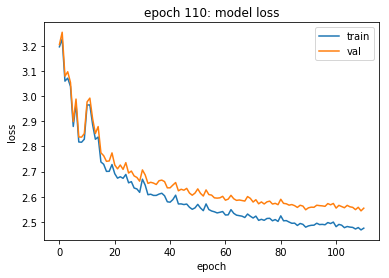

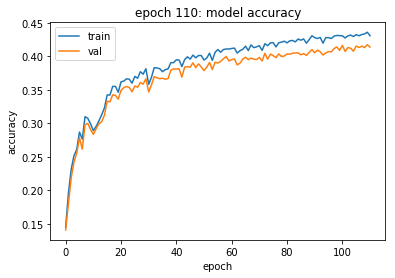



Epoch 111/2000 ...........
Loss train: 2.4602647280411496 
Loss val: 2.538367074070738 
Train accuracy :  0.43845 
Validation accuracy :  0.4216
Alpha:  2.293094507554355


Epoch 112/2000 ...........
Loss train: 2.460552906505706 
Loss val: 2.5349244028955686 
Train accuracy :  0.43345 
Validation accuracy :  0.4163
Alpha:  2.281629035016583


Epoch 113/2000 ...........
Loss train: 2.4639867024419706 
Loss val: 2.5406947303850322 
Train accuracy :  0.43795 
Validation accuracy :  0.417
Alpha:  2.2702208898415


Epoch 114/2000 ...........
Loss train: 2.458940509788711 
Loss val: 2.536179002465463 
Train accuracy :  0.438125 
Validation accuracy :  0.4193
Alpha:  2.2588697853922928


Epoch 115/2000 ...........
Loss train: 2.463958014407126 
Loss val: 2.542655697181512 
Train accuracy :  0.434175 
Validation accuracy :  0.4161
Alpha:  2.2475754364653313


Epoch 116/2000 ...........
Loss train: 2.458975209189317 
Loss val: 2.5408141832152773 
Train accuracy :  0.436375 
Validation accura

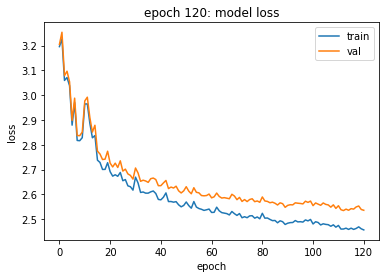

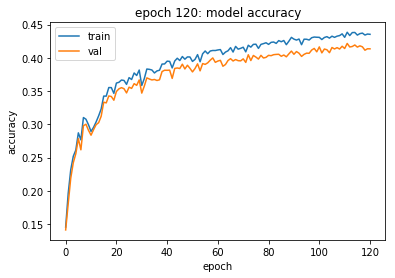



Epoch 121/2000 ...........
Loss train: 2.4488023261480434 
Loss val: 2.5271351349274975 
Train accuracy :  0.43905 
Validation accuracy :  0.4192
Alpha:  2.1809854162503672


Epoch 122/2000 ...........
Loss train: 2.451875399405725 
Loss val: 2.5319382340065557 
Train accuracy :  0.438625 
Validation accuracy :  0.4186
Alpha:  2.1700804891691154


Epoch 123/2000 ...........
Loss train: 2.4508362757637863 
Loss val: 2.5400514367518525 
Train accuracy :  0.438125 
Validation accuracy :  0.4141
Alpha:  2.15923008672327


Epoch 124/2000 ...........
Loss train: 2.4445129470238394 
Loss val: 2.532583160835912 
Train accuracy :  0.441125 
Validation accuracy :  0.4163
Alpha:  2.1484339362896536


Epoch 125/2000 ...........
Loss train: 2.4417808945128163 
Loss val: 2.523252004997549 
Train accuracy :  0.43905 
Validation accuracy :  0.4139
Alpha:  2.137691766608205


Epoch 126/2000 ...........
Loss train: 2.443599677903065 
Loss val: 2.5228369022204604 
Train accuracy :  0.43895 
Validation 

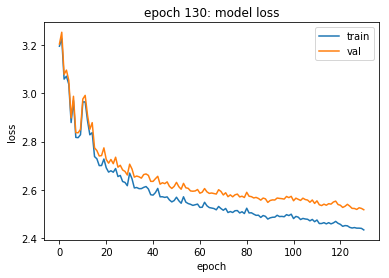

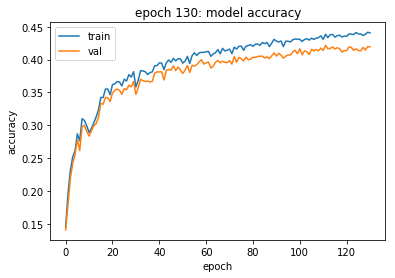



Epoch 131/2000 ...........
Loss train: 2.437171655364814 
Loss val: 2.525102832415381 
Train accuracy :  0.439425 
Validation accuracy :  0.4159
Alpha:  2.0743573237938326


Epoch 132/2000 ...........
Loss train: 2.4361551014880822 
Loss val: 2.5220336162044883 
Train accuracy :  0.441325 
Validation accuracy :  0.4162
Alpha:  2.0639855371748634


Epoch 133/2000 ...........
Loss train: 2.433341010456991 
Loss val: 2.5171239333058057 
Train accuracy :  0.44335 
Validation accuracy :  0.4218
Alpha:  2.053665609488989


Epoch 134/2000 ...........
Loss train: 2.434370779219932 
Loss val: 2.52082618806116 
Train accuracy :  0.440575 
Validation accuracy :  0.417
Alpha:  2.043397281441544


Epoch 135/2000 ...........
Loss train: 2.4346957191440195 
Loss val: 2.519277083192542 
Train accuracy :  0.4423 
Validation accuracy :  0.4225
Alpha:  2.0331802950343363


Epoch 136/2000 ...........
Loss train: 2.429349456461247 
Loss val: 2.5119990716042593 
Train accuracy :  0.44425 
Validation accur

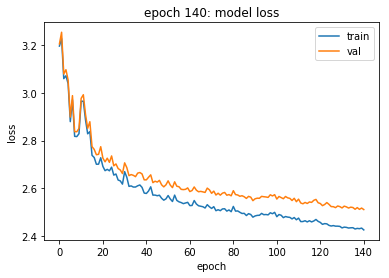

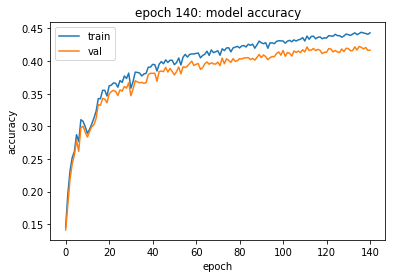



Epoch 141/2000 ...........
Loss train: 2.4254519798082455 
Loss val: 2.5066522839338106 
Train accuracy :  0.442675 
Validation accuracy :  0.4182
Alpha:  1.9729422648661812


Epoch 142/2000 ...........
Loss train: 2.4284079607667524 
Loss val: 2.5084056735732965 
Train accuracy :  0.44245 
Validation accuracy :  0.422
Alpha:  1.9630775535418503


Epoch 143/2000 ...........
Loss train: 2.425929341727511 
Loss val: 2.507000695085609 
Train accuracy :  0.44245 
Validation accuracy :  0.4219
Alpha:  1.9532621657741411


Epoch 144/2000 ...........
Loss train: 2.422991496438993 
Loss val: 2.5036476204602756 
Train accuracy :  0.44435 
Validation accuracy :  0.423
Alpha:  1.9434958549452703


Epoch 145/2000 ...........
Loss train: 2.420081121132242 
Loss val: 2.5052578983020193 
Train accuracy :  0.4469 
Validation accuracy :  0.4222
Alpha:  1.933778375670544


Epoch 146/2000 ...........
Loss train: 2.4272022728447817 
Loss val: 2.5077673905833193 
Train accuracy :  0.4439 
Validation accu

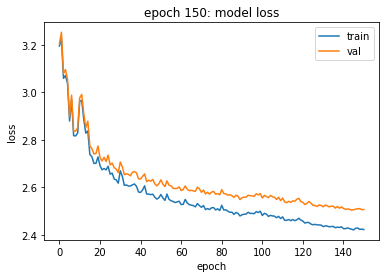

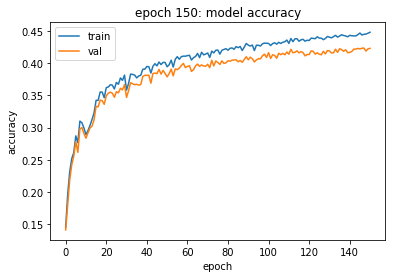



Epoch 151/2000 ...........
Loss train: 2.4166896472224555 
Loss val: 2.5027204697166594 
Train accuracy :  0.448475 
Validation accuracy :  0.4197
Alpha:  1.876485374938309


Epoch 152/2000 ...........
Loss train: 2.4173696073897815 
Loss val: 2.5024603392013183 
Train accuracy :  0.447575 
Validation accuracy :  0.4205
Alpha:  1.8671029480636174


Epoch 153/2000 ...........
Loss train: 2.4175303958072414 
Loss val: 2.502930151126488 
Train accuracy :  0.44555 
Validation accuracy :  0.4218
Alpha:  1.8577674333232994


Epoch 154/2000 ...........
Loss train: 2.417173797194248 
Loss val: 2.5012666798713674 
Train accuracy :  0.44665 
Validation accuracy :  0.4227
Alpha:  1.848478596156683


Epoch 155/2000 ...........
Loss train: 2.421366390380661 
Loss val: 2.5144070482723073 
Train accuracy :  0.442525 
Validation accuracy :  0.4179
Alpha:  1.8392362031758995


Epoch 156/2000 ...........
Loss train: 2.417802227081555 
Loss val: 2.5058861683163816 
Train accuracy :  0.447175 
Validatio

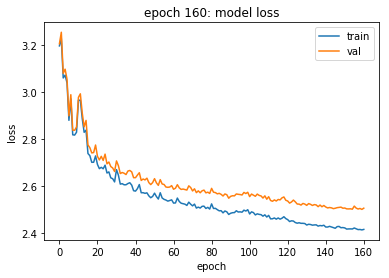

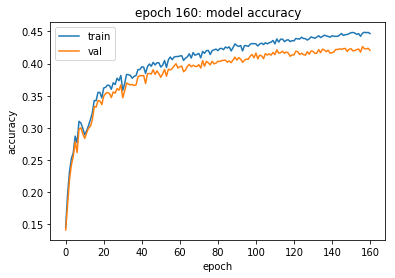



Epoch 161/2000 ...........
Loss train: 2.414314902591492 
Loss val: 2.5047895734993153 
Train accuracy :  0.4477 
Validation accuracy :  0.4199
Alpha:  1.784744249774688


Epoch 162/2000 ...........
Loss train: 2.4103422190189967 
Loss val: 2.501509424294921 
Train accuracy :  0.45055 
Validation accuracy :  0.4239
Alpha:  1.7758205285258144


Epoch 163/2000 ...........
Loss train: 2.412827811711664 
Loss val: 2.5037213009653607 
Train accuracy :  0.447125 
Validation accuracy :  0.4262
Alpha:  1.7669414258831853


Epoch 164/2000 ...........
Loss train: 2.4145351033726548 
Loss val: 2.5031943205259815 
Train accuracy :  0.4493 
Validation accuracy :  0.4221
Alpha:  1.7581067187537693


Epoch 165/2000 ...........
Loss train: 2.4167025964245865 
Loss val: 2.5050778976648735 
Train accuracy :  0.44835 
Validation accuracy :  0.4249
Alpha:  1.7493161851600005


Epoch 166/2000 ...........
Loss train: 2.4128646072897855 
Loss val: 2.500755448117366 
Train accuracy :  0.44655 
Validation ac

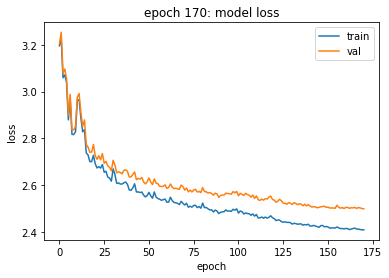

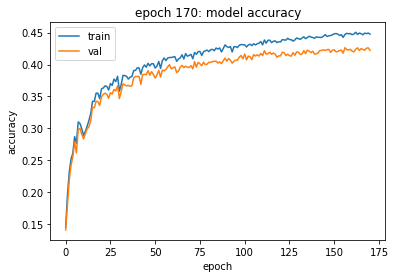



Epoch 171/2000 ...........
Loss train: 2.407839230887871 
Loss val: 2.49595737492631 
Train accuracy :  0.449875 
Validation accuracy :  0.4274
Alpha:  1.6974883362512394


Epoch 172/2000 ...........
Loss train: 2.406792536236226 
Loss val: 2.497612989952299 
Train accuracy :  0.453575 
Validation accuracy :  0.4283
Alpha:  1.6890008945699833


Epoch 173/2000 ...........
Loss train: 2.4054716591363476 
Loss val: 2.4932179277004036 
Train accuracy :  0.45315 
Validation accuracy :  0.429
Alpha:  1.6805558900971334


Epoch 174/2000 ...........
Loss train: 2.4027458499710352 
Loss val: 2.495789127488133 
Train accuracy :  0.4494 
Validation accuracy :  0.4242
Alpha:  1.6721531106466476


Epoch 175/2000 ...........
Loss train: 2.403146199973607 
Loss val: 2.495602917967671 
Train accuracy :  0.450925 
Validation accuracy :  0.4272
Alpha:  1.6637923450934144


Epoch 176/2000 ...........
Loss train: 2.4050146882766903 
Loss val: 2.4935697972743283 
Train accuracy :  0.45045 
Validation acc

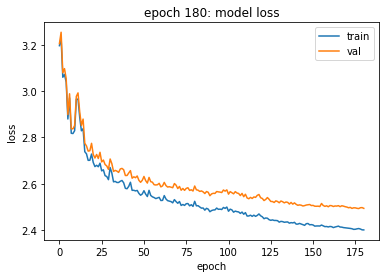

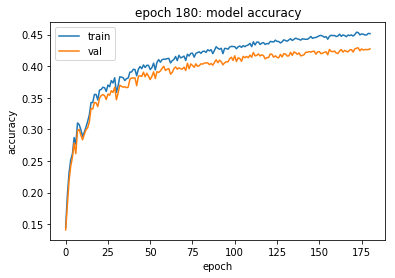



Epoch 181/2000 ...........
Loss train: 2.3968557345078554 
Loss val: 2.4908236385930707 
Train accuracy :  0.45305 
Validation accuracy :  0.4305
Alpha:  1.6144983529560424


Epoch 182/2000 ...........
Loss train: 2.3967826710526956 
Loss val: 2.4902930176676668 
Train accuracy :  0.4517 
Validation accuracy :  0.4286
Alpha:  1.606425861191262


Epoch 183/2000 ...........
Loss train: 2.398304504371101 
Loss val: 2.4931282631897913 
Train accuracy :  0.45375 
Validation accuracy :  0.4288
Alpha:  1.5983937318853056


Epoch 184/2000 ...........
Loss train: 2.3988547587096343 
Loss val: 2.490105886150115 
Train accuracy :  0.450925 
Validation accuracy :  0.4242
Alpha:  1.5904017632258791


Epoch 185/2000 ...........
Loss train: 2.3972897845978394 
Loss val: 2.4875242564741433 
Train accuracy :  0.4516 
Validation accuracy :  0.4259
Alpha:  1.5824497544097498


Epoch 186/2000 ...........
Loss train: 2.3988387076878084 
Loss val: 2.4925792664285193 
Train accuracy :  0.450525 
Validation

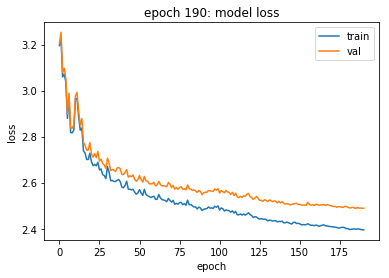

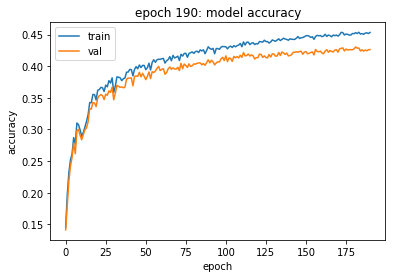



Epoch 191/2000 ...........
Loss train: 2.392726783047919 
Loss val: 2.48531545692081 
Train accuracy :  0.4533 
Validation accuracy :  0.4277
Alpha:  1.5355657391167954


Epoch 192/2000 ...........
Loss train: 2.391276448526989 
Loss val: 2.486065718868288 
Train accuracy :  0.452775 
Validation accuracy :  0.4259
Alpha:  1.5278879104212113


Epoch 193/2000 ...........
Loss train: 2.3927908325449967 
Loss val: 2.4893975234000862 
Train accuracy :  0.451125 
Validation accuracy :  0.4256
Alpha:  1.5202484708691053


Epoch 194/2000 ...........
Loss train: 2.3886815394883207 
Loss val: 2.4860630049151826 
Train accuracy :  0.4573 
Validation accuracy :  0.43
Alpha:  1.5126472285147599


Epoch 195/2000 ...........
Loss train: 2.3888479092133044 
Loss val: 2.4837785260676988 
Train accuracy :  0.45435 
Validation accuracy :  0.4311
Alpha:  1.5050839923721862


Epoch 196/2000 ...........
Loss train: 2.389412851029337 
Loss val: 2.4870641040848414 
Train accuracy :  0.454075 
Validation acc

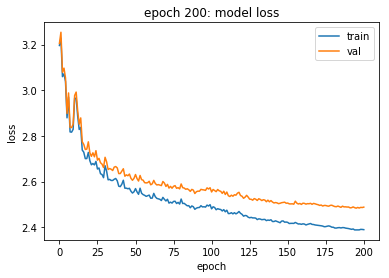

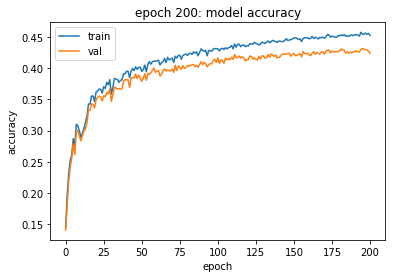



Epoch 201/2000 ...........
Loss train: 2.391769583753145 
Loss val: 2.487972989788767 
Train accuracy :  0.45475 
Validation accuracy :  0.4268
Alpha:  1.460492130470145


Epoch 202/2000 ...........
Loss train: 2.3884431897003147 
Loss val: 2.486607520970809 
Train accuracy :  0.455775 
Validation accuracy :  0.4277
Alpha:  1.4531896698177944


Epoch 203/2000 ...........
Loss train: 2.3888186844395243 
Loss val: 2.4865066027740546 
Train accuracy :  0.453575 
Validation accuracy :  0.4236
Alpha:  1.4459237214687055


Epoch 204/2000 ...........
Loss train: 2.3873621481399256 
Loss val: 2.4855374323789223 
Train accuracy :  0.45705 
Validation accuracy :  0.4281
Alpha:  1.438694102861362


Epoch 205/2000 ...........
Loss train: 2.386266579452326 
Loss val: 2.4833904912257188 
Train accuracy :  0.4565 
Validation accuracy :  0.4308
Alpha:  1.4315006323470552


Epoch 206/2000 ...........
Loss train: 2.38823670535752 
Loss val: 2.48656079017957 
Train accuracy :  0.45535 
Validation accur

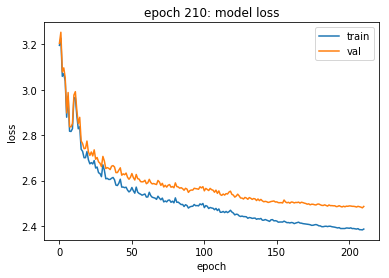

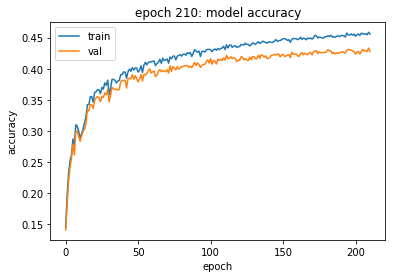



Epoch 211/2000 ...........
Loss train: 2.3874427925651855 
Loss val: 2.4857037942610876 
Train accuracy :  0.456325 
Validation accuracy :  0.4325
Alpha:  1.3890888607556928


Epoch 212/2000 ...........
Loss train: 2.3820401874028407 
Loss val: 2.480665025882612 
Train accuracy :  0.45405 
Validation accuracy :  0.4271
Alpha:  1.3821434164519144


Epoch 213/2000 ...........
Loss train: 2.382848925404862 
Loss val: 2.478602681016861 
Train accuracy :  0.45755 
Validation accuracy :  0.4314
Alpha:  1.3752326993696549


Epoch 214/2000 ...........
Loss train: 2.386857734388714 
Loss val: 2.4825532363018925 
Train accuracy :  0.4561 
Validation accuracy :  0.4294
Alpha:  1.3683565358728065


Epoch 215/2000 ...........
Loss train: 2.382140166755148 
Loss val: 2.4774275644564008 
Train accuracy :  0.4596 
Validation accuracy :  0.4361
Alpha:  1.3615147531934424


Epoch 216/2000 ...........
Loss train: 2.3827654521958057 
Loss val: 2.484128982585964 
Train accuracy :  0.456925 
Validation ac

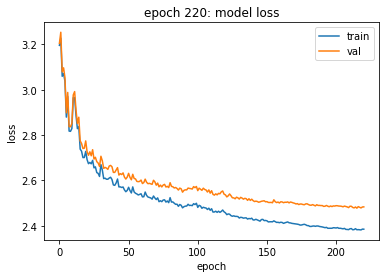

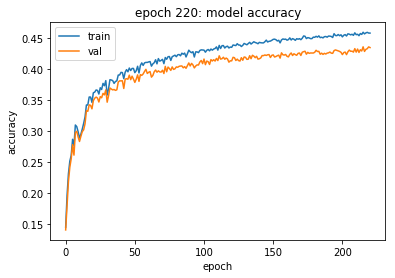



Epoch 221/2000 ...........
Loss train: 2.382966450661165 
Loss val: 2.4818989523032524 
Train accuracy :  0.4578 
Validation accuracy :  0.4347
Alpha:  1.3211764875818972


Epoch 222/2000 ...........
Loss train: 2.3829818564867624 
Loss val: 2.480186655779959 
Train accuracy :  0.45875 
Validation accuracy :  0.432
Alpha:  1.3145706051439878


Epoch 223/2000 ...........
Loss train: 2.3815782956024685 
Loss val: 2.4789382929321584 
Train accuracy :  0.45885 
Validation accuracy :  0.4335
Alpha:  1.307997752118268


Epoch 224/2000 ...........
Loss train: 2.38158283171552 
Loss val: 2.4872766778697484 
Train accuracy :  0.458325 
Validation accuracy :  0.4304
Alpha:  1.3014577633576767


Epoch 225/2000 ...........
Loss train: 2.3803685122343468 
Loss val: 2.4786452747046557 
Train accuracy :  0.459625 
Validation accuracy :  0.4346
Alpha:  1.2949504745408884


Epoch 226/2000 ...........
Loss train: 2.3768241033684023 
Loss val: 2.475571076662145 
Train accuracy :  0.459725 
Validation a

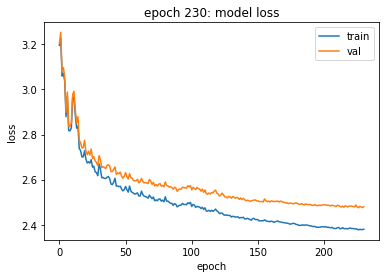

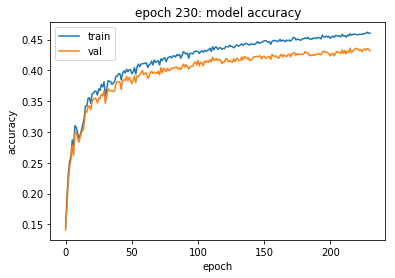



Epoch 231/2000 ...........
Loss train: 2.379882296489287 
Loss val: 2.480969975838917 
Train accuracy :  0.45365 
Validation accuracy :  0.4301
Alpha:  1.2565843414723288


Epoch 232/2000 ...........
Loss train: 2.3754128476925542 
Loss val: 2.4723276960472145 
Train accuracy :  0.4606 
Validation accuracy :  0.4318
Alpha:  1.2503014197649671


Epoch 233/2000 ...........
Loss train: 2.375593679927158 
Loss val: 2.47216959848673 
Train accuracy :  0.46075 
Validation accuracy :  0.4339
Alpha:  1.2440499126661422


Epoch 234/2000 ...........
Loss train: 2.3765357204773117 
Loss val: 2.473710664614103 
Train accuracy :  0.459575 
Validation accuracy :  0.4293
Alpha:  1.2378296631028114


Epoch 235/2000 ...........
Loss train: 2.3760536114293833 
Loss val: 2.4750739787294935 
Train accuracy :  0.461775 
Validation accuracy :  0.4373
Alpha:  1.2316405147872973


Epoch 236/2000 ...........
Loss train: 2.376532606454831 
Loss val: 2.475777046700231 
Train accuracy :  0.4625 
Validation accu

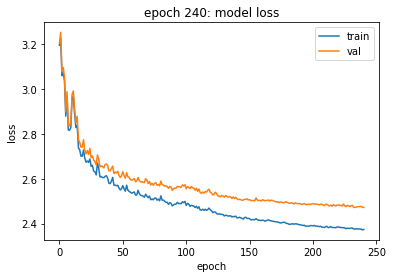

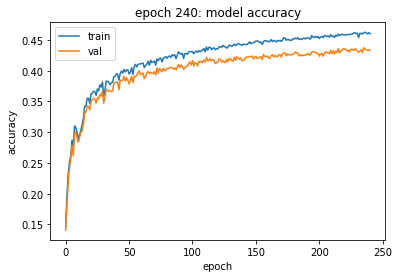



Epoch 241/2000 ...........
Loss train: 2.3728956008589757 
Loss val: 2.4712686463696536 
Train accuracy :  0.461025 
Validation accuracy :  0.4331
Alpha:  1.1951500969589928


Epoch 242/2000 ...........
Loss train: 2.3721064446894213 
Loss val: 2.471929661586071 
Train accuracy :  0.46225 
Validation accuracy :  0.4371
Alpha:  1.1891743464741977


Epoch 243/2000 ...........
Loss train: 2.370801713465662 
Loss val: 2.4707806945117774 
Train accuracy :  0.4611 
Validation accuracy :  0.4361
Alpha:  1.1832284747418267


Epoch 244/2000 ...........
Loss train: 2.373027740378869 
Loss val: 2.4742509971840345 
Train accuracy :  0.459875 
Validation accuracy :  0.4308
Alpha:  1.1773123323681176


Epoch 245/2000 ...........
Loss train: 2.369176822193483 
Loss val: 2.472978374733482 
Train accuracy :  0.460775 
Validation accuracy :  0.4303
Alpha:  1.171425770706277


Epoch 246/2000 ...........
Loss train: 2.368377601062827 
Loss val: 2.4707681025768764 
Train accuracy :  0.46 
Validation accu

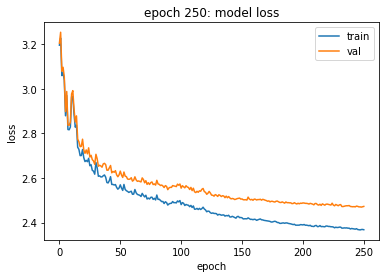

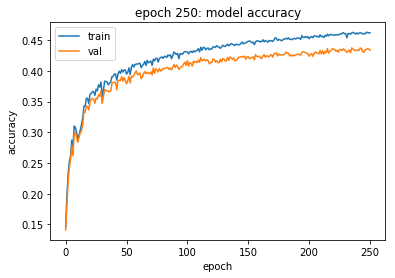



Epoch 251/2000 ...........
Loss train: 2.3680740821117467 
Loss val: 2.4703161273987675 
Train accuracy :  0.461375 
Validation accuracy :  0.4314
Alpha:  1.1367193646448475


Epoch 252/2000 ...........
Loss train: 2.367449796483138 
Loss val: 2.471060015093335 
Train accuracy :  0.463725 
Validation accuracy :  0.4363
Alpha:  1.1310357678216232


Epoch 253/2000 ...........
Loss train: 2.367443494236739 
Loss val: 2.47181851716306 
Train accuracy :  0.4621 
Validation accuracy :  0.4337
Alpha:  1.125380588982515


Epoch 254/2000 ...........
Loss train: 2.364680643990798 
Loss val: 2.4705937364096444 
Train accuracy :  0.46375 
Validation accuracy :  0.4323
Alpha:  1.1197536860376025


Epoch 255/2000 ...........
Loss train: 2.3641933189897366 
Loss val: 2.471661108173418 
Train accuracy :  0.459925 
Validation accuracy :  0.431
Alpha:  1.1141549176074146


Epoch 256/2000 ...........
Loss train: 2.364869942570591 
Loss val: 2.470662476117308 
Train accuracy :  0.461525 
Validation accu

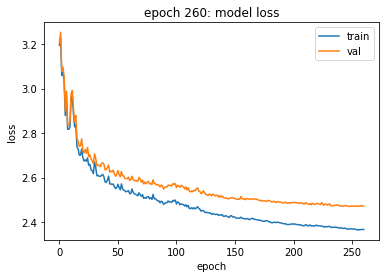

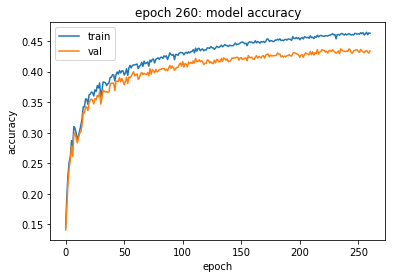



Epoch 261/2000 ...........
Loss train: 2.366075418353475 
Loss val: 2.4720385588515845 
Train accuracy :  0.462825 
Validation accuracy :  0.432
Alpha:  1.08114530321033


Epoch 262/2000 ...........
Loss train: 2.3639751364437527 
Loss val: 2.4690326445793 
Train accuracy :  0.46265 
Validation accuracy :  0.4333
Alpha:  1.0757395766942783


Epoch 263/2000 ...........
Loss train: 2.363619951732583 
Loss val: 2.467917533898434 
Train accuracy :  0.4636 
Validation accuracy :  0.4355
Alpha:  1.070360878810807


Epoch 264/2000 ...........
Loss train: 2.3643493261616753 
Loss val: 2.4685368150492923 
Train accuracy :  0.463975 
Validation accuracy :  0.4335
Alpha:  1.0650090744167529


Epoch 265/2000 ...........
Loss train: 2.3637018906996325 
Loss val: 2.4677669426613935 
Train accuracy :  0.464125 
Validation accuracy :  0.4336
Alpha:  1.0596840290446692


Epoch 266/2000 ...........
Loss train: 2.3631454315295617 
Loss val: 2.470898700806319 
Train accuracy :  0.46385 
Validation accur

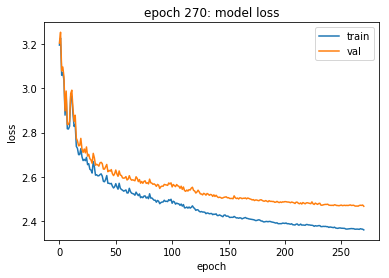

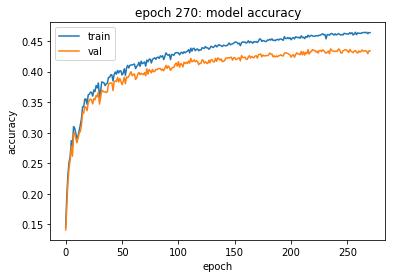



Epoch 271/2000 ...........
Loss train: 2.3615898590882667 
Loss val: 2.470569687248286 
Train accuracy :  0.4655 
Validation accuracy :  0.4351
Alpha:  1.0282882503888335


Epoch 272/2000 ...........
Loss train: 2.358332329526974 
Loss val: 2.466789424526037 
Train accuracy :  0.466225 
Validation accuracy :  0.4309
Alpha:  1.0231468091368894


Epoch 273/2000 ...........
Loss train: 2.3602521284063482 
Loss val: 2.469838661541554 
Train accuracy :  0.46465 
Validation accuracy :  0.4347
Alpha:  1.018031075091205


Epoch 274/2000 ...........
Loss train: 2.357200060560367 
Loss val: 2.4671442629992932 
Train accuracy :  0.46515 
Validation accuracy :  0.4339
Alpha:  1.0129409197157488


Epoch 275/2000 ...........
Loss train: 2.3566473058522774 
Loss val: 2.4641218568542618 
Train accuracy :  0.4655 
Validation accuracy :  0.4345
Alpha:  1.00787621511717


Epoch 276/2000 ...........
Loss train: 2.3590109916891144 
Loss val: 2.4659085556419202 
Train accuracy :  0.466625 
Validation accu

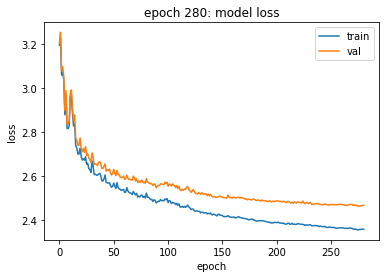

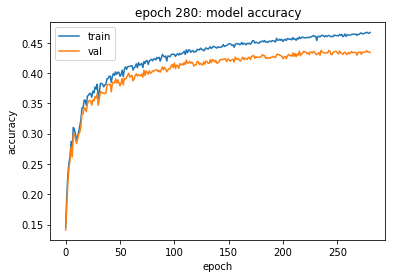



Epoch 281/2000 ...........
Loss train: 2.358249313939611 
Loss val: 2.464533583325865 
Train accuracy :  0.46635 
Validation accuracy :  0.4328
Alpha:  0.9780153719837437


Epoch 282/2000 ...........
Loss train: 2.3593007301563955 
Loss val: 2.465687644545785 
Train accuracy :  0.464875 
Validation accuracy :  0.4323
Alpha:  0.973125295123825


Epoch 283/2000 ...........
Loss train: 2.3584692641036025 
Loss val: 2.4641800730142984 
Train accuracy :  0.46715 
Validation accuracy :  0.4342
Alpha:  0.9682596686482058


Epoch 284/2000 ...........
Loss train: 2.3564743120088054 
Loss val: 2.4596378179155285 
Train accuracy :  0.466 
Validation accuracy :  0.4358
Alpha:  0.9634183703049648


Epoch 285/2000 ...........
Loss train: 2.3525368658624077 
Loss val: 2.4595402408197953 
Train accuracy :  0.46535 
Validation accuracy :  0.4347
Alpha:  0.95860127845344


Epoch 286/2000 ...........
Loss train: 2.3565145321660377 
Loss val: 2.464442286895076 
Train accuracy :  0.46535 
Validation accu

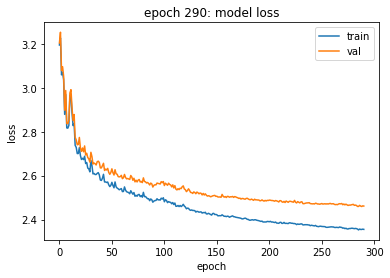

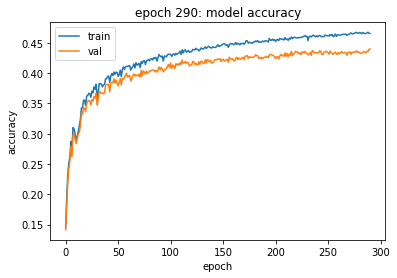



Epoch 291/2000 ...........
Loss train: 2.355501490285908 
Loss val: 2.460982317042709 
Train accuracy :  0.46495 
Validation accuracy :  0.4371
Alpha:  0.9302003280449889


Epoch 292/2000 ...........
Loss train: 2.3540305697466417 
Loss val: 2.458279642819769 
Train accuracy :  0.464775 
Validation accuracy :  0.4359
Alpha:  0.925549326404764


Epoch 293/2000 ...........
Loss train: 2.3577324239401842 
Loss val: 2.4625319660113267 
Train accuracy :  0.465575 
Validation accuracy :  0.4359
Alpha:  0.9209215797727401


Epoch 294/2000 ...........
Loss train: 2.3573816523813123 
Loss val: 2.4635192406212996 
Train accuracy :  0.465775 
Validation accuracy :  0.4357
Alpha:  0.9163169718738764


Epoch 295/2000 ...........
Loss train: 2.3580295030809615 
Loss val: 2.463509010324279 
Train accuracy :  0.46635 
Validation accuracy :  0.4333
Alpha:  0.911735387014507


Epoch 296/2000 ...........
Loss train: 2.3545365913352403 
Loss val: 2.462655093142734 
Train accuracy :  0.46635 
Validation 

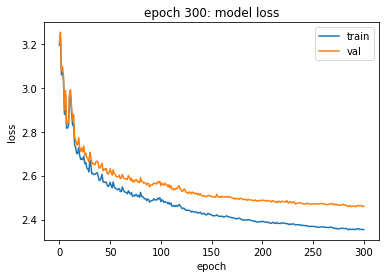

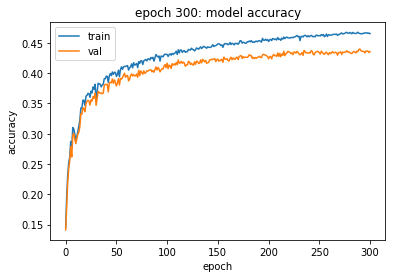



Epoch 301/2000 ...........
Loss train: 2.3524921891653894 
Loss val: 2.460065732867157 
Train accuracy :  0.4651 
Validation accuracy :  0.4365
Alpha:  0.8847229553661732


Epoch 302/2000 ...........
Loss train: 2.350044628049116 
Loss val: 2.460111885770136 
Train accuracy :  0.4676 
Validation accuracy :  0.4369
Alpha:  0.8802993405893423


Epoch 303/2000 ...........
Loss train: 2.3513993915478144 
Loss val: 2.458820018330578 
Train accuracy :  0.46555 
Validation accuracy :  0.4363
Alpha:  0.8758978438863956


Epoch 304/2000 ...........
Loss train: 2.350441667576564 
Loss val: 2.457927985645854 
Train accuracy :  0.467425 
Validation accuracy :  0.4361
Alpha:  0.8715183546669636


Epoch 305/2000 ...........
Loss train: 2.35000024481467 
Loss val: 2.459169395147726 
Train accuracy :  0.466475 
Validation accuracy :  0.4367
Alpha:  0.8671607628936288


Epoch 306/2000 ...........
Loss train: 2.3494586666310475 
Loss val: 2.458028150936571 
Train accuracy :  0.46595 
Validation accura

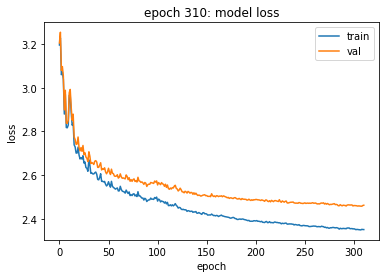

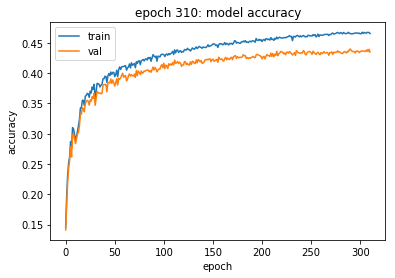



Epoch 311/2000 ...........
Loss train: 2.3482417061678507 
Loss val: 2.4575406459432525 
Train accuracy :  0.4665 
Validation accuracy :  0.4383
Alpha:  0.8414689655043841


Epoch 312/2000 ...........
Loss train: 2.3493495782432885 
Loss val: 2.4572671695046955 
Train accuracy :  0.465875 
Validation accuracy :  0.4373
Alpha:  0.8372616206768622


Epoch 313/2000 ...........
Loss train: 2.350441824714895 
Loss val: 2.4573396073144633 
Train accuracy :  0.465375 
Validation accuracy :  0.4363
Alpha:  0.8330753125734779


Epoch 314/2000 ...........
Loss train: 2.3512598712020463 
Loss val: 2.4609878033244 
Train accuracy :  0.467125 
Validation accuracy :  0.439
Alpha:  0.8289099360106105


Epoch 315/2000 ...........
Loss train: 2.350114808222896 
Loss val: 2.4594314211305774 
Train accuracy :  0.46825 
Validation accuracy :  0.4398
Alpha:  0.8247653863305574


Epoch 316/2000 ...........
Loss train: 2.350843792482072 
Loss val: 2.4587955276974958 
Train accuracy :  0.4657 
Validation ac

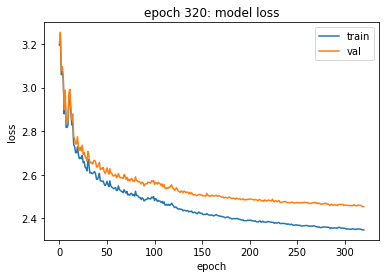

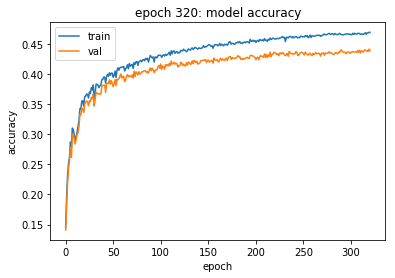



Epoch 321/2000 ...........
Loss train: 2.3488598567625627 
Loss val: 2.455630550198529 
Train accuracy :  0.46885 
Validation accuracy :  0.4392
Alpha:  0.8003296575637728


Epoch 322/2000 ...........
Loss train: 2.348114184092249 
Loss val: 2.4577753462312257 
Train accuracy :  0.470475 
Validation accuracy :  0.4404
Alpha:  0.7963280092759539


Epoch 323/2000 ...........
Loss train: 2.346342988894898 
Loss val: 2.454023623693527 
Train accuracy :  0.470425 
Validation accuracy :  0.44
Alpha:  0.7923463692295741


Epoch 324/2000 ...........
Loss train: 2.348586036515002 
Loss val: 2.4549561857427227 
Train accuracy :  0.46855 
Validation accuracy :  0.4382
Alpha:  0.7883846373834262


Epoch 325/2000 ...........
Loss train: 2.3461935345976834 
Loss val: 2.4544821902014364 
Train accuracy :  0.468975 
Validation accuracy :  0.4375
Alpha:  0.7844427141965091


Epoch 326/2000 ...........
Loss train: 2.344919674774763 
Loss val: 2.454320545736115 
Train accuracy :  0.469125 
Validation a

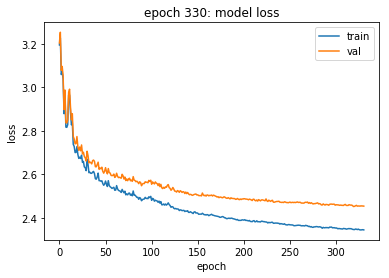

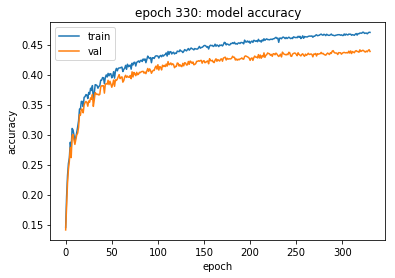



Epoch 331/2000 ...........
Loss train: 2.34505255170517 
Loss val: 2.4553791616652543 
Train accuracy :  0.4695 
Validation accuracy :  0.4388
Alpha:  0.7612016450211064


Epoch 332/2000 ...........
Loss train: 2.34411412345578 
Loss val: 2.453260292707659 
Train accuracy :  0.469125 
Validation accuracy :  0.4409
Alpha:  0.7573956367960009


Epoch 333/2000 ...........
Loss train: 2.345749600242715 
Loss val: 2.454057188902195 
Train accuracy :  0.4695 
Validation accuracy :  0.4385
Alpha:  0.7536086586120209


Epoch 334/2000 ...........
Loss train: 2.3440537735169835 
Loss val: 2.453210584386072 
Train accuracy :  0.469525 
Validation accuracy :  0.437
Alpha:  0.7498406153189607


Epoch 335/2000 ...........
Loss train: 2.34481481319115 
Loss val: 2.4562262593744095 
Train accuracy :  0.46925 
Validation accuracy :  0.4373
Alpha:  0.746091412242366


Epoch 336/2000 ...........
Loss train: 2.3447797550505647 
Loss val: 2.454079385336442 
Train accuracy :  0.46865 
Validation accuracy 

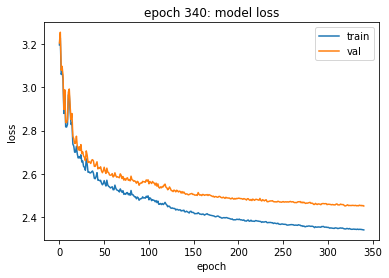

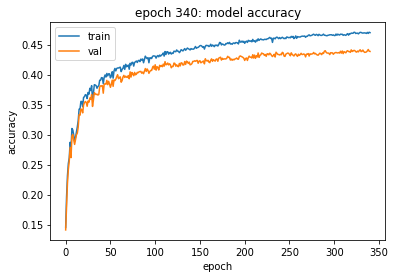



Epoch 341/2000 ...........
Loss train: 2.340682720014863 
Loss val: 2.4542849172460666 
Train accuracy :  0.470425 
Validation accuracy :  0.4395
Alpha:  0.7239865959067847


Epoch 342/2000 ...........
Loss train: 2.3417324443915035 
Loss val: 2.4542421843323776 
Train accuracy :  0.46945 
Validation accuracy :  0.4403
Alpha:  0.7203666629272508


Epoch 343/2000 ...........
Loss train: 2.3411257288295713 
Loss val: 2.45282291777383 
Train accuracy :  0.4694 
Validation accuracy :  0.4389
Alpha:  0.7167648296126146


Epoch 344/2000 ...........
Loss train: 2.341358443199728 
Loss val: 2.4529091376495247 
Train accuracy :  0.470375 
Validation accuracy :  0.4408
Alpha:  0.7131810054645514


Epoch 345/2000 ...........
Loss train: 2.3401303600445877 
Loss val: 2.4508844768708524 
Train accuracy :  0.470625 
Validation accuracy :  0.4398
Alpha:  0.7096151004372286


Epoch 346/2000 ...........
Loss train: 2.3429098241878954 
Loss val: 2.4531261261880224 
Train accuracy :  0.467875 
Validati

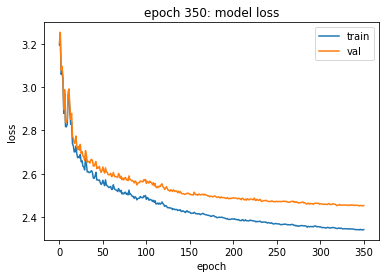

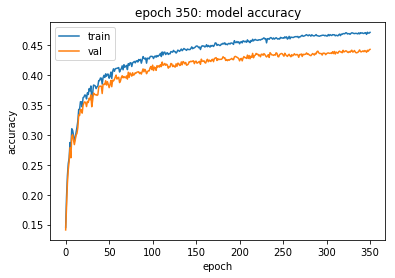



Epoch 351/2000 ...........
Loss train: 2.3425690963472525 
Loss val: 2.452899826682243 
Train accuracy :  0.4702 
Validation accuracy :  0.4374
Alpha:  0.6885909856883718


Epoch 352/2000 ...........
Loss train: 2.3432002254728608 
Loss val: 2.45573441125166 
Train accuracy :  0.469475 
Validation accuracy :  0.439
Alpha:  0.68514803075993


Epoch 353/2000 ...........
Loss train: 2.3410629523069533 
Loss val: 2.449754095708529 
Train accuracy :  0.4692 
Validation accuracy :  0.4411
Alpha:  0.6817222906061303


Epoch 354/2000 ...........
Loss train: 2.3423111483838785 
Loss val: 2.449888437920482 
Train accuracy :  0.469025 
Validation accuracy :  0.4417
Alpha:  0.6783136791530997


Epoch 355/2000 ...........
Loss train: 2.3399788882344223 
Loss val: 2.449007733983075 
Train accuracy :  0.46945 
Validation accuracy :  0.4392
Alpha:  0.6749221107573342


Epoch 356/2000 ...........
Loss train: 2.3386761465742074 
Loss val: 2.4495139194288504 
Train accuracy :  0.4694 
Validation accura

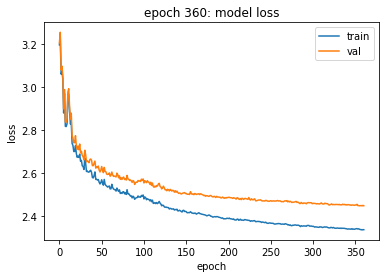

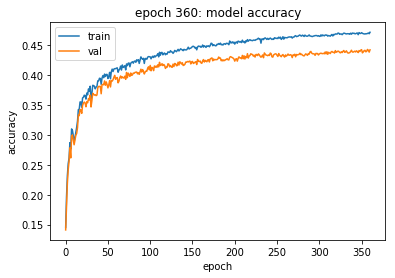



Epoch 361/2000 ...........
Loss train: 2.337883517165336 
Loss val: 2.4486067051965574 
Train accuracy :  0.470925 
Validation accuracy :  0.4394
Alpha:  0.6549258622356218


Epoch 362/2000 ...........
Loss train: 2.337288148009998 
Loss val: 2.448312340594965 
Train accuracy :  0.468375 
Validation accuracy :  0.4416
Alpha:  0.6516512329244437


Epoch 363/2000 ...........
Loss train: 2.337264711567799 
Loss val: 2.449802995417891 
Train accuracy :  0.4707 
Validation accuracy :  0.4439
Alpha:  0.6483929767598214


Epoch 364/2000 ...........
Loss train: 2.336271455966402 
Loss val: 2.4498130139902936 
Train accuracy :  0.46955 
Validation accuracy :  0.4421
Alpha:  0.6451510118760223


Epoch 365/2000 ...........
Loss train: 2.336423717529639 
Loss val: 2.4518176288875937 
Train accuracy :  0.469775 
Validation accuracy :  0.4442
Alpha:  0.6419252568166421


Epoch 366/2000 ...........
Loss train: 2.336705698453651 
Loss val: 2.449435860000204 
Train accuracy :  0.470025 
Validation ac

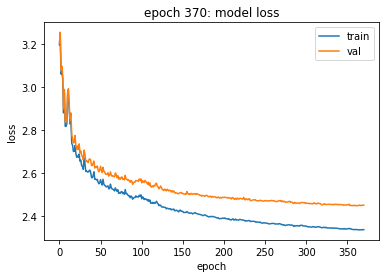

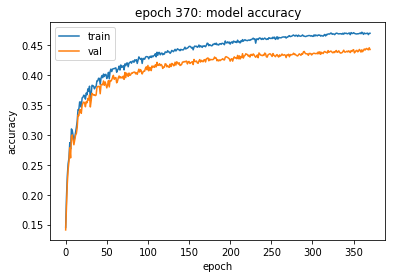



Epoch 371/2000 ...........
Loss train: 2.33930421986465 
Loss val: 2.45307087556317 
Train accuracy :  0.469525 
Validation accuracy :  0.4434
Alpha:  0.6229066222763304


Epoch 372/2000 ...........
Loss train: 2.3381523744440753 
Loss val: 2.449941405202552 
Train accuracy :  0.470775 
Validation accuracy :  0.4458
Alpha:  0.6197920891649488


Epoch 373/2000 ...........
Loss train: 2.3368888421036953 
Loss val: 2.4518334579199976 
Train accuracy :  0.470425 
Validation accuracy :  0.4439
Alpha:  0.6166931287191241


Epoch 374/2000 ...........
Loss train: 2.3365018007330267 
Loss val: 2.452898790964899 
Train accuracy :  0.47165 
Validation accuracy :  0.4431
Alpha:  0.6136096630755284


Epoch 375/2000 ...........
Loss train: 2.3349990040655366 
Loss val: 2.450559685847148 
Train accuracy :  0.47225 
Validation accuracy :  0.4458
Alpha:  0.6105416147601508


Epoch 376/2000 ...........
Loss train: 2.3372881105266297 
Loss val: 2.4529529336912397 
Train accuracy :  0.47145 
Validation 

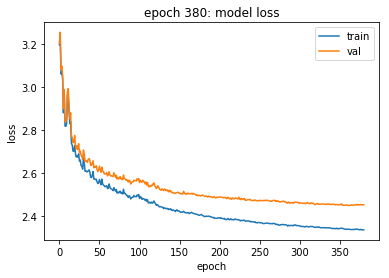

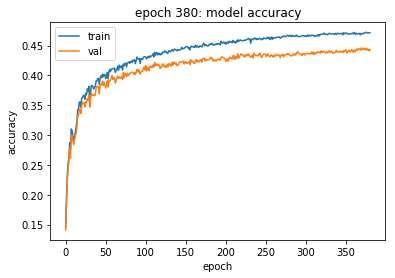



Epoch 381/2000 ...........
Loss train: 2.3352965072363 
Loss val: 2.451414600344826 
Train accuracy :  0.47225 
Validation accuracy :  0.4427
Alpha:  0.5924527987812338


Epoch 382/2000 ...........
Loss train: 2.335099788609021 
Loss val: 2.4519589382874645 
Train accuracy :  0.47225 
Validation accuracy :  0.4416
Alpha:  0.5894905347873276


Epoch 383/2000 ...........
Loss train: 2.334580116868555 
Loss val: 2.4499287923092865 
Train accuracy :  0.46995 
Validation accuracy :  0.4416
Alpha:  0.586543082113391


Epoch 384/2000 ...........
Loss train: 2.3364271000369663 
Loss val: 2.4536676155748856 
Train accuracy :  0.469475 
Validation accuracy :  0.4392
Alpha:  0.5836103667028241


Epoch 385/2000 ...........
Loss train: 2.3356107582173165 
Loss val: 2.4529415608104044 
Train accuracy :  0.470825 
Validation accuracy :  0.4417
Alpha:  0.58069231486931


Epoch 386/2000 ...........
Loss train: 2.335372979446788 
Loss val: 2.453224235770608 
Train accuracy :  0.46985 
Validation accur

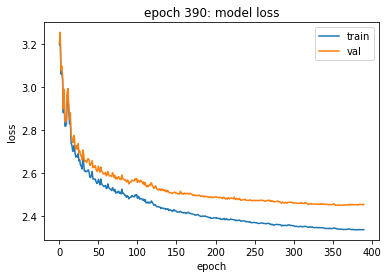

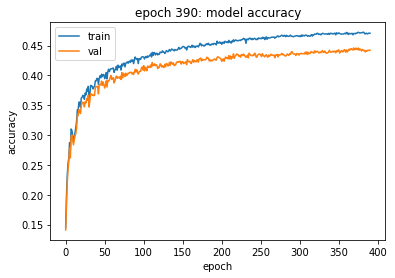



Epoch 391/2000 ...........
Loss train: 2.336339204624921 
Loss val: 2.454945927021429 
Train accuracy :  0.47075 
Validation accuracy :  0.4411
Alpha:  0.563487858743631


Epoch 392/2000 ...........
Loss train: 2.335343991192906 
Loss val: 2.4545999580112667 
Train accuracy :  0.472675 
Validation accuracy :  0.4416
Alpha:  0.5606704194499129


Epoch 393/2000 ...........
Loss train: 2.33323889036682 
Loss val: 2.4517460493447287 
Train accuracy :  0.47175 
Validation accuracy :  0.4413
Alpha:  0.5578670673526633


Epoch 394/2000 ...........
Loss train: 2.3333704001269377 
Loss val: 2.4514638349350113 
Train accuracy :  0.471225 
Validation accuracy :  0.4408
Alpha:  0.5550777320159


Epoch 395/2000 ...........
Loss train: 2.335380790869888 
Loss val: 2.45539500903776 
Train accuracy :  0.47135 
Validation accuracy :  0.4409
Alpha:  0.5523023433558205


Epoch 396/2000 ...........
Loss train: 2.3347194299810354 
Loss val: 2.456410223442467 
Train accuracy :  0.470675 
Validation accura

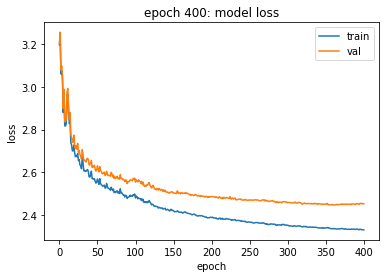

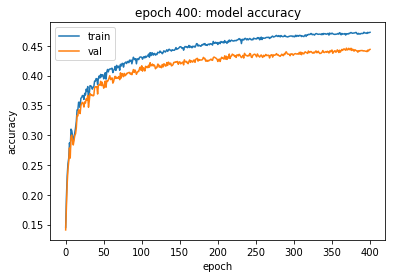



Epoch 401/2000 ...........
Loss train: 2.333453060611232 
Loss val: 2.45539673067154 
Train accuracy :  0.472925 
Validation accuracy :  0.4433
Alpha:  0.5359390108455334


Epoch 402/2000 ...........
Loss train: 2.3328246301073285 
Loss val: 2.4528023707570714 
Train accuracy :  0.471925 
Validation accuracy :  0.4409
Alpha:  0.5332593157913057


Epoch 403/2000 ...........
Loss train: 2.331634739448691 
Loss val: 2.4525664295266525 
Train accuracy :  0.4708 
Validation accuracy :  0.4426
Alpha:  0.5305930192123491


Epoch 404/2000 ...........
Loss train: 2.335120622177278 
Loss val: 2.4552541558149104 
Train accuracy :  0.471325 
Validation accuracy :  0.4402
Alpha:  0.5279400541162874


Epoch 405/2000 ...........
Loss train: 2.3351023090231977 
Loss val: 2.456940414731902 
Train accuracy :  0.4725 
Validation accuracy :  0.4403
Alpha:  0.525300353845706


Epoch 406/2000 ...........
Loss train: 2.332811238492139 
Loss val: 2.454047910945946 
Train accuracy :  0.4741 
Validation accur

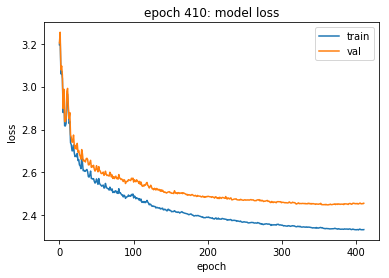

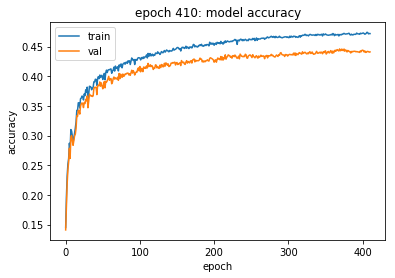



Epoch 411/2000 ...........
Loss train: 2.3322101371317148 
Loss val: 2.452878523469472 
Train accuracy :  0.47255 
Validation accuracy :  0.4426
Alpha:  0.5097370225269919


Epoch 412/2000 ...........
Loss train: 2.3314537697608366 
Loss val: 2.4510998350737836 
Train accuracy :  0.4734 
Validation accuracy :  0.4428
Alpha:  0.507188337414357


Epoch 413/2000 ...........
Loss train: 2.3315592056147816 
Loss val: 2.4527286324809308 
Train accuracy :  0.47255 
Validation accuracy :  0.4414
Alpha:  0.5046523957272852


Epoch 414/2000 ...........
Loss train: 2.333016497939101 
Loss val: 2.4548433398481357 
Train accuracy :  0.4727 
Validation accuracy :  0.4403
Alpha:  0.5021291337486488


Epoch 415/2000 ...........
Loss train: 2.3312571350962807 
Loss val: 2.4510715992180407 
Train accuracy :  0.472725 
Validation accuracy :  0.4426
Alpha:  0.4996184880799055


Epoch 416/2000 ...........
Loss train: 2.3313306346343268 
Loss val: 2.4501369677472637 
Train accuracy :  0.472825 
Validation

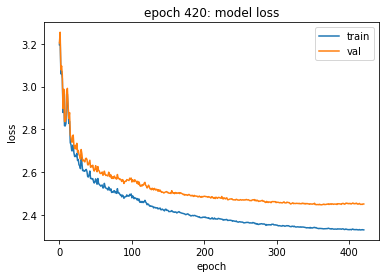

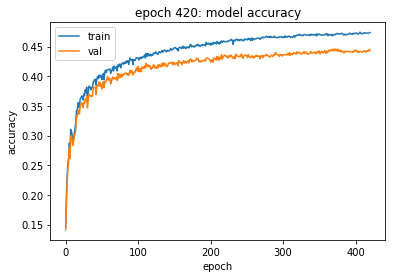



Epoch 421/2000 ...........
Loss train: 2.330628041614976 
Loss val: 2.4506251517402977 
Train accuracy :  0.473025 
Validation accuracy :  0.4419
Alpha:  0.4848160459988814


Epoch 422/2000 ...........
Loss train: 2.329900574390369 
Loss val: 2.4489676759827295 
Train accuracy :  0.4721 
Validation accuracy :  0.4407
Alpha:  0.482391965768887


Epoch 423/2000 ...........
Loss train: 2.332346745973073 
Loss val: 2.4524106804477226 
Train accuracy :  0.47225 
Validation accuracy :  0.4409
Alpha:  0.47998000594004253


Epoch 424/2000 ...........
Loss train: 2.3304523662474756 
Loss val: 2.449630784522033 
Train accuracy :  0.471175 
Validation accuracy :  0.4398
Alpha:  0.47758010591034233


Epoch 425/2000 ...........
Loss train: 2.3306843116654314 
Loss val: 2.4497002210942913 
Train accuracy :  0.471275 
Validation accuracy :  0.4427
Alpha:  0.4751922053807906


Epoch 426/2000 ...........
Loss train: 2.329011979489671 
Loss val: 2.4467658017760185 
Train accuracy :  0.471975 
Validati

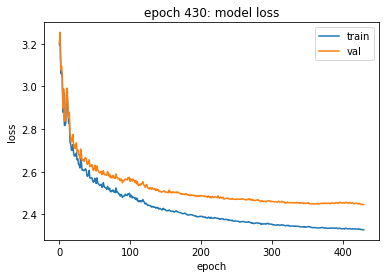

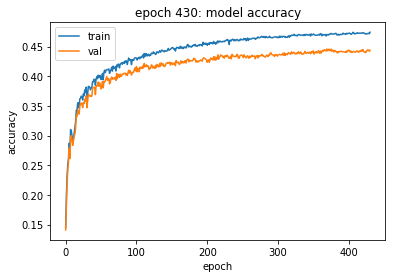



Epoch 431/2000 ...........
Loss train: 2.3269560049361777 
Loss val: 2.444073686724435 
Train accuracy :  0.473925 
Validation accuracy :  0.4443
Alpha:  0.4611134527618957


Epoch 432/2000 ...........
Loss train: 2.3266197013470404 
Loss val: 2.446412896367872 
Train accuracy :  0.47285 
Validation accuracy :  0.4443
Alpha:  0.4588078854980862


Epoch 433/2000 ...........
Loss train: 2.3274974530328567 
Loss val: 2.4474209450518343 
Train accuracy :  0.47245 
Validation accuracy :  0.4438
Alpha:  0.45651384607059575


Epoch 434/2000 ...........
Loss train: 2.3267147187744506 
Loss val: 2.445882511115344 
Train accuracy :  0.473125 
Validation accuracy :  0.4406
Alpha:  0.4542312768402428


Epoch 435/2000 ...........
Loss train: 2.3272075329490756 
Loss val: 2.4456306273909085 
Train accuracy :  0.4718 
Validation accuracy :  0.4412
Alpha:  0.45196012045604156


Epoch 436/2000 ...........
Loss train: 2.32710523688047 
Loss val: 2.4454333501801857 
Train accuracy :  0.472325 
Validati

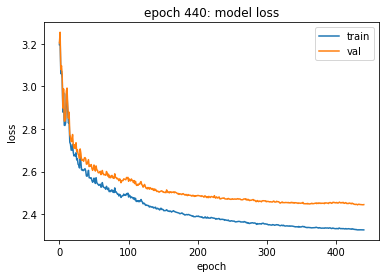

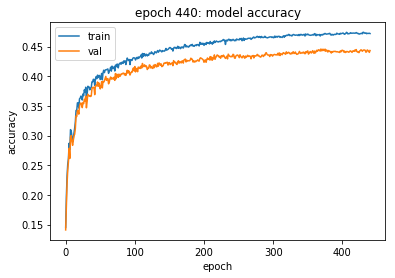



Epoch 441/2000 ...........
Loss train: 2.328192640190946 
Loss val: 2.4471851161155023 
Train accuracy :  0.473075 
Validation accuracy :  0.4423
Alpha:  0.4385696762158891


Epoch 442/2000 ...........
Loss train: 2.3262264488008335 
Loss val: 2.4456724434859587 
Train accuracy :  0.472225 
Validation accuracy :  0.4422
Alpha:  0.43637682783480963


Epoch 443/2000 ...........
Loss train: 2.3261619520312165 
Loss val: 2.444947068673456 
Train accuracy :  0.47245 
Validation accuracy :  0.4431
Alpha:  0.4341949436956356


Epoch 444/2000 ...........
Loss train: 2.3262364567602423 
Loss val: 2.445949822224208 
Train accuracy :  0.472475 
Validation accuracy :  0.4418
Alpha:  0.43202396897715745


Epoch 445/2000 ...........
Loss train: 2.3260342288551694 
Loss val: 2.4463938675021426 
Train accuracy :  0.473475 
Validation accuracy :  0.4442
Alpha:  0.42986384913227166


Epoch 446/2000 ...........
Loss train: 2.326621254619969 
Loss val: 2.447807727033094 
Train accuracy :  0.473925 
Vali

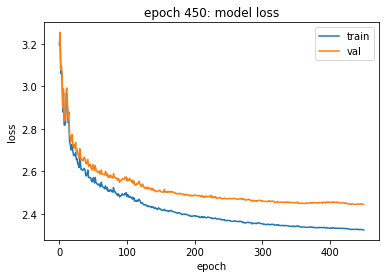

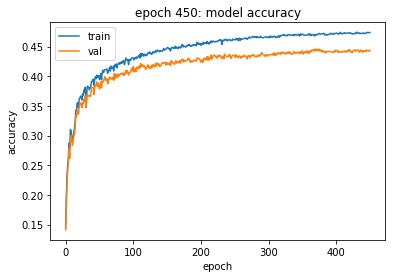



Epoch 451/2000 ...........
Loss train: 2.3241681723593404 
Loss val: 2.4437905468345025 
Train accuracy :  0.47415 
Validation accuracy :  0.4433
Alpha:  0.4171280619640256


Epoch 452/2000 ...........
Loss train: 2.3238142186558814 
Loss val: 2.443076808418322 
Train accuracy :  0.47465 
Validation accuracy :  0.4418
Alpha:  0.41504242165420546


Epoch 453/2000 ...........
Loss train: 2.323816624190723 
Loss val: 2.443465837063287 
Train accuracy :  0.4743 
Validation accuracy :  0.4416
Alpha:  0.4129672095459344


Epoch 454/2000 ...........
Loss train: 2.3235557355884042 
Loss val: 2.4431037799831845 
Train accuracy :  0.473975 
Validation accuracy :  0.442
Alpha:  0.41090237349820474


Epoch 455/2000 ...........
Loss train: 2.3244189391068315 
Loss val: 2.4445531526084086 
Train accuracy :  0.474 
Validation accuracy :  0.4415
Alpha:  0.40884786163071374


Epoch 456/2000 ...........
Loss train: 2.3246079569479927 
Loss val: 2.4445724853066393 
Train accuracy :  0.47455 
Validation

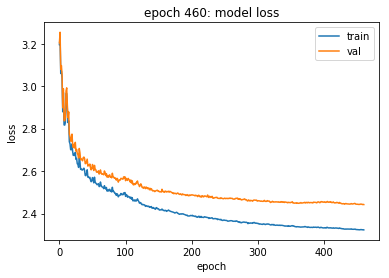

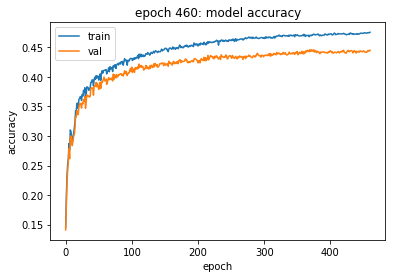



Epoch 461/2000 ...........
Loss train: 2.3231778489842467 
Loss val: 2.4448565468144037 
Train accuracy :  0.4752 
Validation accuracy :  0.4422
Alpha:  0.39673472543553895


Epoch 462/2000 ...........
Loss train: 2.3221826187997188 
Loss val: 2.4430069728935906 
Train accuracy :  0.47515 
Validation accuracy :  0.442
Alpha:  0.39475105180836123


Epoch 463/2000 ...........
Loss train: 2.3223678838132495 
Loss val: 2.443158518417133 
Train accuracy :  0.47445 
Validation accuracy :  0.4444
Alpha:  0.3927772965493194


Epoch 464/2000 ...........
Loss train: 2.322754784202118 
Loss val: 2.443090732580678 
Train accuracy :  0.475275 
Validation accuracy :  0.4452
Alpha:  0.39081341006657283


Epoch 465/2000 ...........
Loss train: 2.323193520063398 
Loss val: 2.444488561411969 
Train accuracy :  0.47535 
Validation accuracy :  0.4432
Alpha:  0.38885934301624


Epoch 466/2000 ...........
Loss train: 2.322225796637956 
Loss val: 2.4429690986634474 
Train accuracy :  0.47515 
Validation ac

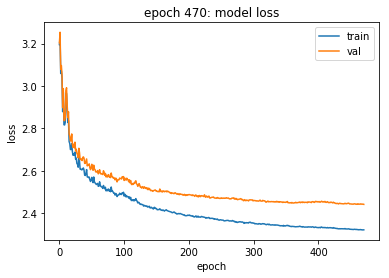

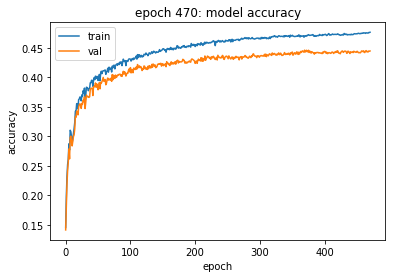



Epoch 471/2000 ...........
Loss train: 2.3222139666324884 
Loss val: 2.4432746974725554 
Train accuracy :  0.4763 
Validation accuracy :  0.4443
Alpha:  0.3773384164692976


Epoch 472/2000 ...........
Loss train: 2.3218066608871615 
Loss val: 2.4433212548815266 
Train accuracy :  0.4749 
Validation accuracy :  0.4424
Alpha:  0.3754517243869511


Epoch 473/2000 ...........
Loss train: 2.3222285888449323 
Loss val: 2.4435449313498774 
Train accuracy :  0.474575 
Validation accuracy :  0.4432
Alpha:  0.37357446576501635


Epoch 474/2000 ...........
Loss train: 2.3216742851852836 
Loss val: 2.4424136606737092 
Train accuracy :  0.4746 
Validation accuracy :  0.4438
Alpha:  0.3717065934361913


Epoch 475/2000 ...........
Loss train: 2.320820405586069 
Loss val: 2.44256292600196 
Train accuracy :  0.476675 
Validation accuracy :  0.4462
Alpha:  0.3698480604690103


Epoch 476/2000 ...........
Loss train: 2.320619984192465 
Loss val: 2.443089065089571 
Train accuracy :  0.4752 
Validation ac

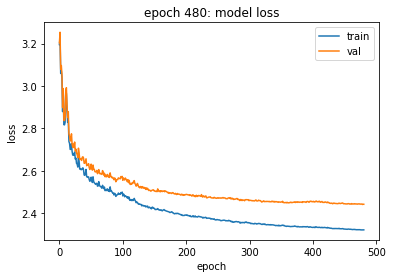

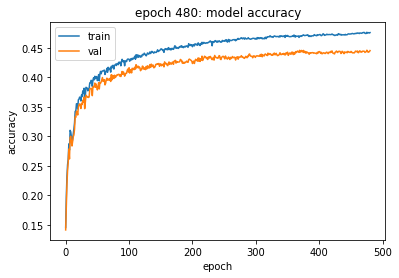



Epoch 481/2000 ...........
Loss train: 2.321034906870482 
Loss val: 2.4422475299121227 
Train accuracy :  0.4765 
Validation accuracy :  0.444
Alpha:  0.3588903905178613


Epoch 482/2000 ...........
Loss train: 2.32081906862613 
Loss val: 2.4413775443896557 
Train accuracy :  0.475925 
Validation accuracy :  0.4457
Alpha:  0.357095938565272


Epoch 483/2000 ...........
Loss train: 2.321670893746235 
Loss val: 2.442618883558307 
Train accuracy :  0.475825 
Validation accuracy :  0.4453
Alpha:  0.3553104588724456


Epoch 484/2000 ...........
Loss train: 2.3219123308842136 
Loss val: 2.4446747513716547 
Train accuracy :  0.474625 
Validation accuracy :  0.4461
Alpha:  0.35353390657808337


Epoch 485/2000 ...........
Loss train: 2.321528491536082 
Loss val: 2.443358997216701 
Train accuracy :  0.475975 
Validation accuracy :  0.4446
Alpha:  0.35176623704519294


Epoch 486/2000 ...........
Loss train: 2.3214602060179264 
Loss val: 2.4431091975745063 
Train accuracy :  0.47535 
Validation 

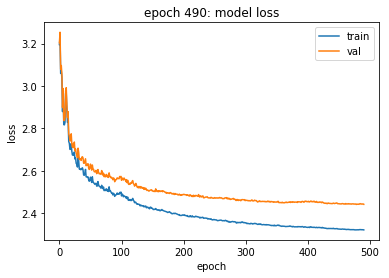

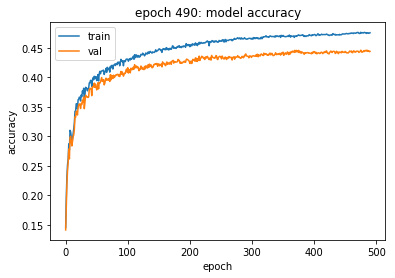



Epoch 491/2000 ...........
Loss train: 2.319885171708935 
Loss val: 2.4421265822136933 
Train accuracy :  0.4758 
Validation accuracy :  0.4462
Alpha:  0.3413442861483549


Epoch 492/2000 ...........
Loss train: 2.3209339823117725 
Loss val: 2.443886489187029 
Train accuracy :  0.476775 
Validation accuracy :  0.4454
Alpha:  0.3396375647176131


Epoch 493/2000 ...........
Loss train: 2.320634852897517 
Loss val: 2.443815373924322 
Train accuracy :  0.475275 
Validation accuracy :  0.4468
Alpha:  0.33793937689402503


Epoch 494/2000 ...........
Loss train: 2.3201774642444146 
Loss val: 2.443276756022313 
Train accuracy :  0.475875 
Validation accuracy :  0.4448
Alpha:  0.3362496800095549


Epoch 495/2000 ...........
Loss train: 2.319511157422719 
Loss val: 2.442356499985755 
Train accuracy :  0.47605 
Validation accuracy :  0.4468
Alpha:  0.3345684316095071


Epoch 496/2000 ...........
Loss train: 2.3198189700706515 
Loss val: 2.4405100503015595 
Train accuracy :  0.475375 
Validation

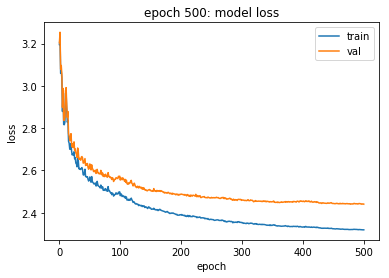

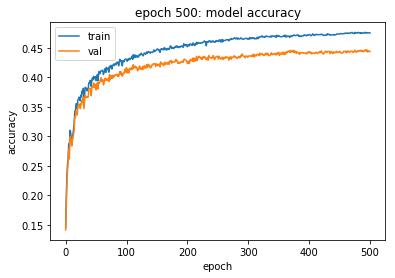



Epoch 501/2000 ...........
Loss train: 2.3189126248943217 
Loss val: 2.44050023064954 
Train accuracy :  0.475875 
Validation accuracy :  0.4447
Alpha:  0.3246560085323076


Epoch 502/2000 ...........
Loss train: 2.320202629054691 
Loss val: 2.44193021017142 
Train accuracy :  0.4747 
Validation accuracy :  0.445
Alpha:  0.32303272848964604


Epoch 503/2000 ...........
Loss train: 2.3196624715390297 
Loss val: 2.44083516931647 
Train accuracy :  0.475125 
Validation accuracy :  0.4463
Alpha:  0.3214175648471978


Epoch 504/2000 ...........
Loss train: 2.3198447797866435 
Loss val: 2.4405223758451373 
Train accuracy :  0.475425 
Validation accuracy :  0.4457
Alpha:  0.31981047702296184


Epoch 505/2000 ...........
Loss train: 2.320526678632843 
Loss val: 2.4399128462671635 
Train accuracy :  0.475675 
Validation accuracy :  0.4451
Alpha:  0.318211424637847


Epoch 506/2000 ...........
Loss train: 2.3206891049068883 
Loss val: 2.441107581120807 
Train accuracy :  0.475225 
Validation a

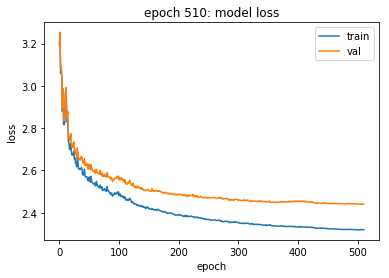

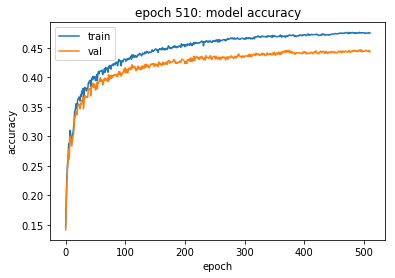



Epoch 511/2000 ...........
Loss train: 2.319520952066911 
Loss val: 2.4395139354516266 
Train accuracy :  0.4747 
Validation accuracy :  0.444
Alpha:  0.30878361863165976


Epoch 512/2000 ...........
Loss train: 2.3195095180410275 
Loss val: 2.4402261192267996 
Train accuracy :  0.47485 
Validation accuracy :  0.4448
Alpha:  0.30723970053850147


Epoch 513/2000 ...........
Loss train: 2.319044329674632 
Loss val: 2.4394441568715 
Train accuracy :  0.47495 
Validation accuracy :  0.4449
Alpha:  0.305703502035809


Epoch 514/2000 ...........
Loss train: 2.3184308358840617 
Loss val: 2.4391480141126616 
Train accuracy :  0.475575 
Validation accuracy :  0.4438
Alpha:  0.3041749845256299


Epoch 515/2000 ...........
Loss train: 2.31830237822317 
Loss val: 2.440074356707573 
Train accuracy :  0.476225 
Validation accuracy :  0.4454
Alpha:  0.30265410960300176


Epoch 516/2000 ...........
Loss train: 2.318344946622386 
Loss val: 2.4402901384157225 
Train accuracy :  0.4766 
Validation accu

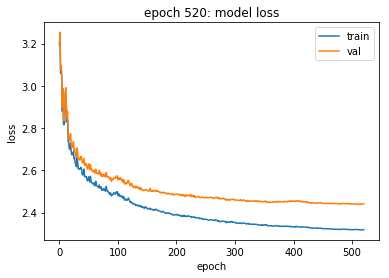

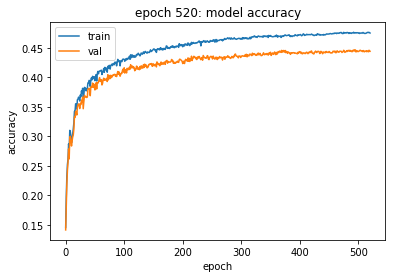



Epoch 521/2000 ...........
Loss train: 2.3190633095777007 
Loss val: 2.4418904058039814 
Train accuracy :  0.47675 
Validation accuracy :  0.4447
Alpha:  0.293687227802451


Epoch 522/2000 ...........
Loss train: 2.3187664215249795 
Loss val: 2.440022209170608 
Train accuracy :  0.4766 
Validation accuracy :  0.4463
Alpha:  0.2922187916634387


Epoch 523/2000 ...........
Loss train: 2.319159713768226 
Loss val: 2.4402034914517188 
Train accuracy :  0.475575 
Validation accuracy :  0.4463
Alpha:  0.29075769770512155


Epoch 524/2000 ...........
Loss train: 2.3182982096738267 
Loss val: 2.440391168909808 
Train accuracy :  0.476125 
Validation accuracy :  0.4469
Alpha:  0.28930390921659593


Epoch 525/2000 ...........
Loss train: 2.317852070881708 
Loss val: 2.439535564252549 
Train accuracy :  0.476925 
Validation accuracy :  0.4456
Alpha:  0.28785738967051294


Epoch 526/2000 ...........
Loss train: 2.3180998529378796 
Loss val: 2.4394018418483654 
Train accuracy :  0.475125 
Validat

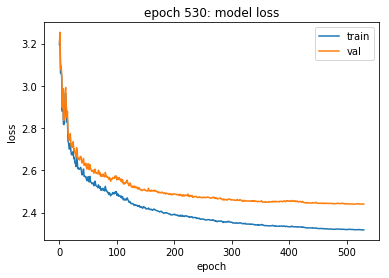

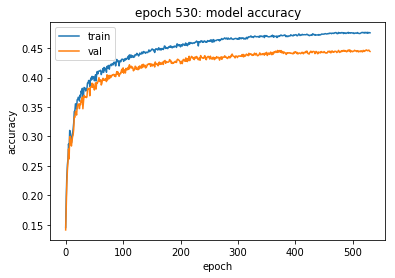



Epoch 531/2000 ...........
Loss train: 2.3181591977596328 
Loss val: 2.4388437160612684 
Train accuracy :  0.475325 
Validation accuracy :  0.4446
Alpha:  0.27932889755132


Epoch 532/2000 ...........
Loss train: 2.31703339956666 
Loss val: 2.439284519281773 
Train accuracy :  0.476075 
Validation accuracy :  0.4449
Alpha:  0.2779322530635634


Epoch 533/2000 ...........
Loss train: 2.3174960727991607 
Loss val: 2.440305691494056 
Train accuracy :  0.47495 
Validation accuracy :  0.4453
Alpha:  0.2765425917982456


Epoch 534/2000 ...........
Loss train: 2.317754346133968 
Loss val: 2.4398972088275523 
Train accuracy :  0.476525 
Validation accuracy :  0.4446
Alpha:  0.27515987883925436


Epoch 535/2000 ...........
Loss train: 2.317366187241652 
Loss val: 2.439952715262328 
Train accuracy :  0.475025 
Validation accuracy :  0.444
Alpha:  0.27378407944505806


Epoch 536/2000 ...........
Loss train: 2.3184126941714873 
Loss val: 2.4401367321356275 
Train accuracy :  0.475025 
Validation

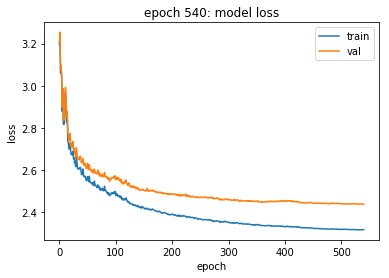

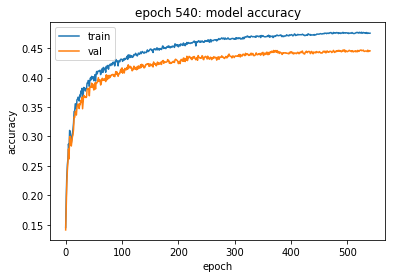



Epoch 541/2000 ...........
Loss train: 2.317971862153961 
Loss val: 2.4389575025550747 
Train accuracy :  0.474775 
Validation accuracy :  0.4449
Alpha:  0.2656725441928961


Epoch 542/2000 ...........
Loss train: 2.317262107287924 
Loss val: 2.438308656752625 
Train accuracy :  0.47555 
Validation accuracy :  0.4453
Alpha:  0.2643441814719316


Epoch 543/2000 ...........
Loss train: 2.317022728789074 
Loss val: 2.438919499317332 
Train accuracy :  0.4751 
Validation accuracy :  0.4462
Alpha:  0.26302246056457196


Epoch 544/2000 ...........
Loss train: 2.3168324661177486 
Loss val: 2.4394765729672776 
Train accuracy :  0.475025 
Validation accuracy :  0.4466
Alpha:  0.2617073482617491


Epoch 545/2000 ...........
Loss train: 2.3165466895813833 
Loss val: 2.4388115707948854 
Train accuracy :  0.4761 
Validation accuracy :  0.447
Alpha:  0.2603988115204403


Epoch 546/2000 ...........
Loss train: 2.3164716851804146 
Loss val: 2.439629530404789 
Train accuracy :  0.4768 
Validation acc

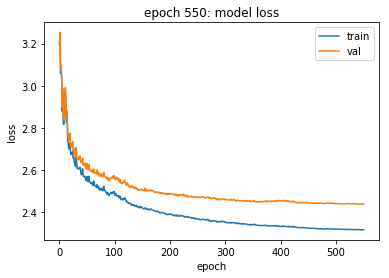

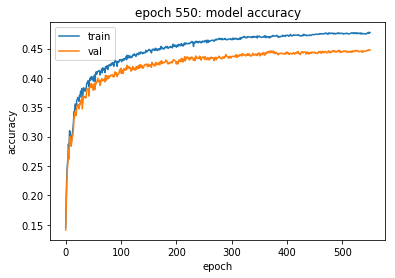



Epoch 551/2000 ...........
Loss train: 2.316654058800025 
Loss val: 2.4395623945734273 
Train accuracy :  0.476225 
Validation accuracy :  0.4462
Alpha:  0.2526838481684789


Epoch 552/2000 ...........
Loss train: 2.316492168747293 
Loss val: 2.4396762906605667 
Train accuracy :  0.47655 
Validation accuracy :  0.4464
Alpha:  0.2514204289276365


Epoch 553/2000 ...........
Loss train: 2.31657333057323 
Loss val: 2.440289304509379 
Train accuracy :  0.476925 
Validation accuracy :  0.4443
Alpha:  0.2501633267829983


Epoch 554/2000 ...........
Loss train: 2.3166486360830025 
Loss val: 2.4390446562376527 
Train accuracy :  0.47565 
Validation accuracy :  0.4443
Alpha:  0.2489125101490833


Epoch 555/2000 ...........
Loss train: 2.31601036187105 
Loss val: 2.4392958424010556 
Train accuracy :  0.47705 
Validation accuracy :  0.4474
Alpha:  0.24766794759833788


Epoch 556/2000 ...........
Loss train: 2.3161070318349166 
Loss val: 2.4392711051439684 
Train accuracy :  0.47785 
Validation 

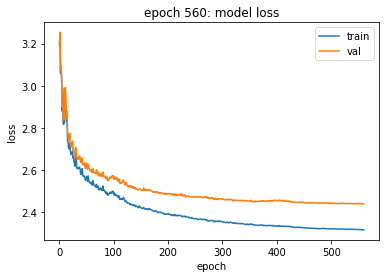

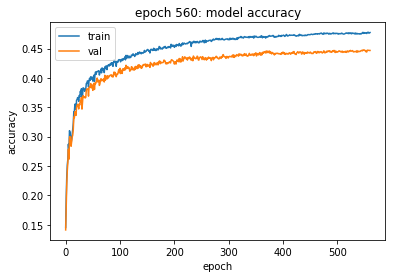



Epoch 561/2000 ...........
Loss train: 2.3148788762011128 
Loss val: 2.439600010368262 
Train accuracy :  0.478025 
Validation accuracy :  0.4478
Alpha:  0.24033016779811517


Epoch 562/2000 ...........
Loss train: 2.314741786437475 
Loss val: 2.438687354426024 
Train accuracy :  0.477575 
Validation accuracy :  0.4486
Alpha:  0.2391285169591246


Epoch 563/2000 ...........
Loss train: 2.3147363203696636 
Loss val: 2.438622763346717 
Train accuracy :  0.477325 
Validation accuracy :  0.4473
Alpha:  0.23793287437432897


Epoch 564/2000 ...........
Loss train: 2.314187177041729 
Loss val: 2.438504967782804 
Train accuracy :  0.4762 
Validation accuracy :  0.4468
Alpha:  0.23674321000245732


Epoch 565/2000 ...........
Loss train: 2.3142492348249974 
Loss val: 2.4376952676890267 
Train accuracy :  0.477 
Validation accuracy :  0.4458
Alpha:  0.23555949395244502


Epoch 566/2000 ...........
Loss train: 2.314317892359671 
Loss val: 2.4384740895712564 
Train accuracy :  0.477525 
Validatio

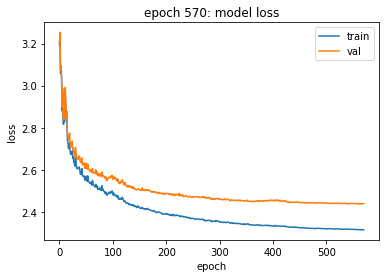

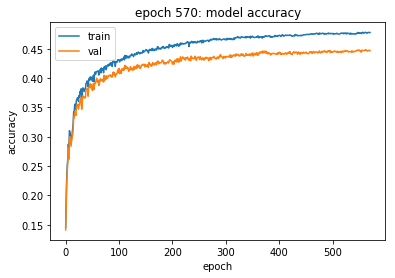



Epoch 571/2000 ...........
Loss train: 2.3142603908964903 
Loss val: 2.4392367982355827 
Train accuracy :  0.476925 
Validation accuracy :  0.4466
Alpha:  0.22858045724932613


Epoch 572/2000 ...........
Loss train: 2.3141214940771455 
Loss val: 2.4386231679754333 
Train accuracy :  0.477225 
Validation accuracy :  0.4456
Alpha:  0.2274375549630795


Epoch 573/2000 ...........
Loss train: 2.313842734225745 
Loss val: 2.438276236311636 
Train accuracy :  0.476275 
Validation accuracy :  0.4456
Alpha:  0.2263003671882641


Epoch 574/2000 ...........
Loss train: 2.31400314469066 
Loss val: 2.4373312625461154 
Train accuracy :  0.475925 
Validation accuracy :  0.4473
Alpha:  0.22516886535232278


Epoch 575/2000 ...........
Loss train: 2.3132582140591995 
Loss val: 2.437819945803526 
Train accuracy :  0.4767 
Validation accuracy :  0.4473
Alpha:  0.22404302102556117


Epoch 576/2000 ...........
Loss train: 2.313653287607937 
Loss val: 2.4380694258197386 
Train accuracy :  0.476425 
Valida

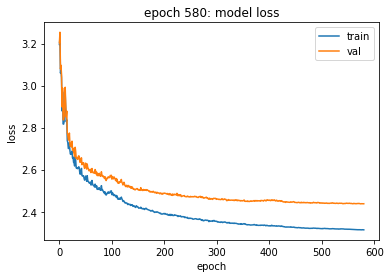

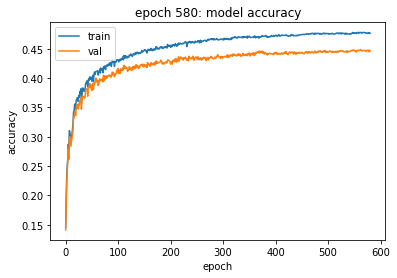



Epoch 581/2000 ...........
Loss train: 2.3132179936682347 
Loss val: 2.4380970493811147 
Train accuracy :  0.47725 
Validation accuracy :  0.4456
Alpha:  0.2174051885163324


Epoch 582/2000 ...........
Loss train: 2.313222043981536 
Loss val: 2.4382464344040256 
Train accuracy :  0.477725 
Validation accuracy :  0.4464
Alpha:  0.21631816257375072


Epoch 583/2000 ...........
Loss train: 2.3132924142670457 
Loss val: 2.437943914640444 
Train accuracy :  0.47755 
Validation accuracy :  0.4458
Alpha:  0.21523657176088196


Epoch 584/2000 ...........
Loss train: 2.3133078736570543 
Loss val: 2.438698305807427 
Train accuracy :  0.477625 
Validation accuracy :  0.4459
Alpha:  0.21416038890207756


Epoch 585/2000 ...........
Loss train: 2.3132493964974183 
Loss val: 2.439132775026409 
Train accuracy :  0.477375 
Validation accuracy :  0.4459
Alpha:  0.21308958695756716


Epoch 586/2000 ...........
Loss train: 2.3127858434589146 
Loss val: 2.438227600219484 
Train accuracy :  0.4778 
Valida

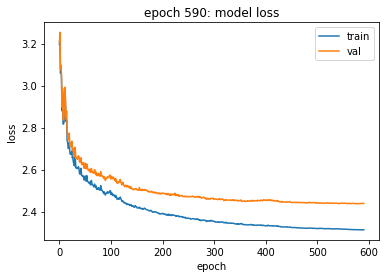

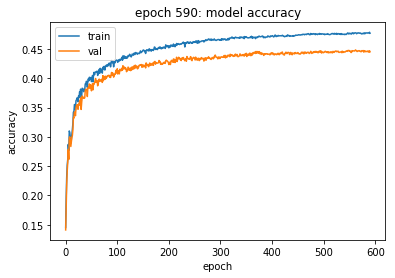



Epoch 591/2000 ...........
Loss train: 2.3136261885661957 
Loss val: 2.4386509835543126 
Train accuracy :  0.477825 
Validation accuracy :  0.4463
Alpha:  0.20677627721370465


Epoch 592/2000 ...........
Loss train: 2.313297897589956 
Loss val: 2.4385923943002417 
Train accuracy :  0.4778 
Validation accuracy :  0.4478
Alpha:  0.20574239582763612


Epoch 593/2000 ...........
Loss train: 2.3128596704569166 
Loss val: 2.43807155791165 
Train accuracy :  0.478325 
Validation accuracy :  0.4471
Alpha:  0.20471368384849795


Epoch 594/2000 ...........
Loss train: 2.3129429267729464 
Loss val: 2.4391103072952154 
Train accuracy :  0.478125 
Validation accuracy :  0.4484
Alpha:  0.20369011542925544


Epoch 595/2000 ...........
Loss train: 2.3124626727694464 
Loss val: 2.43855078527533 
Train accuracy :  0.47945 
Validation accuracy :  0.4479
Alpha:  0.20267166485210916


Epoch 596/2000 ...........
Loss train: 2.3126211256879263 
Loss val: 2.4384351967860787 
Train accuracy :  0.4786 
Valida

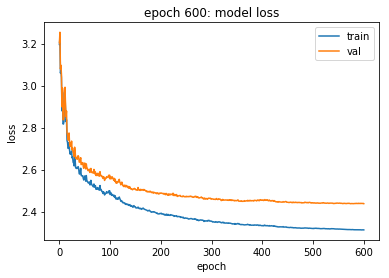

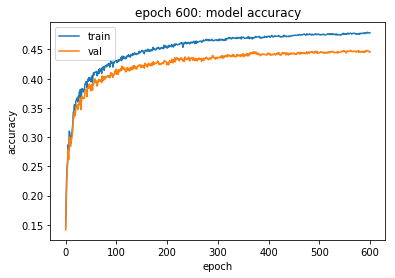



Epoch 601/2000 ...........
Loss train: 2.312321362346755 
Loss val: 2.4380002676009536 
Train accuracy :  0.47875 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 602/2000 ...........
Loss train: 2.3118593772869866 
Loss val: 2.43709692100325 
Train accuracy :  0.478225 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 603/2000 ...........
Loss train: 2.3121722146885686 
Loss val: 2.4376712409531525 
Train accuracy :  0.477675 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 604/2000 ...........
Loss train: 2.3124843646919535 
Loss val: 2.438279474676725 
Train accuracy :  0.47705 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 605/2000 ...........
Loss train: 2.3121349260442945 
Loss val: 2.4382526930424624 
Train accuracy :  0.4776 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 606/2000 ...........
Loss train: 2.3121156068212216 
Loss val: 2.4372869378784197 
Train accuracy :  0.4783 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 607/2000 ...........
Loss train: 2.3

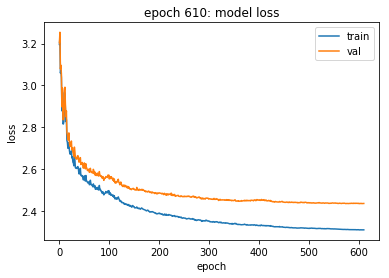

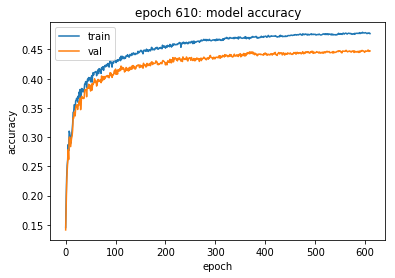



Epoch 611/2000 ...........
Loss train: 2.3123277442249366 
Loss val: 2.4376265510020407 
Train accuracy :  0.478125 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 612/2000 ...........
Loss train: 2.3114542629797765 
Loss val: 2.4374585123200903 
Train accuracy :  0.478525 
Validation accuracy :  0.4481
Alpha:  0.2


Epoch 613/2000 ...........
Loss train: 2.3117700647128268 
Loss val: 2.4379654486905773 
Train accuracy :  0.478425 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 614/2000 ...........
Loss train: 2.311504404904343 
Loss val: 2.437874059404045 
Train accuracy :  0.478225 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 615/2000 ...........
Loss train: 2.311546890339682 
Loss val: 2.4371137192125274 
Train accuracy :  0.477825 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 616/2000 ...........
Loss train: 2.3116896261002817 
Loss val: 2.4373780038589867 
Train accuracy :  0.4773 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 617/2000 ...........
Loss train: 

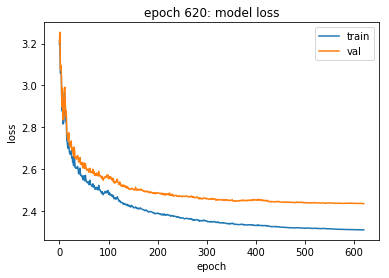

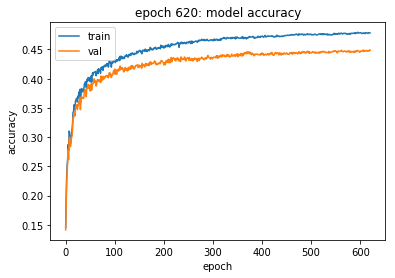



Epoch 621/2000 ...........
Loss train: 2.31114887077624 
Loss val: 2.436695400750398 
Train accuracy :  0.477125 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 622/2000 ...........
Loss train: 2.311106973588662 
Loss val: 2.4357820805523382 
Train accuracy :  0.478 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 623/2000 ...........
Loss train: 2.3113513562517247 
Loss val: 2.4367757789188547 
Train accuracy :  0.478425 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 624/2000 ...........
Loss train: 2.3112101363184006 
Loss val: 2.4373118806991725 
Train accuracy :  0.4785 
Validation accuracy :  0.4481
Alpha:  0.2


Epoch 625/2000 ...........
Loss train: 2.310755606121628 
Loss val: 2.436440826129729 
Train accuracy :  0.47855 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 626/2000 ...........
Loss train: 2.310859792747736 
Loss val: 2.437305944935754 
Train accuracy :  0.47805 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 627/2000 ...........
Loss train: 2.310837

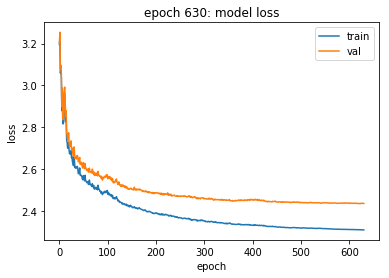

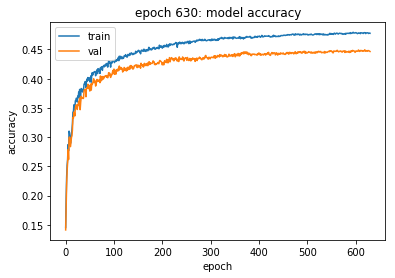



Epoch 631/2000 ...........
Loss train: 2.3100874805904716 
Loss val: 2.4368228851050486 
Train accuracy :  0.4771 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 632/2000 ...........
Loss train: 2.3100976274993323 
Loss val: 2.4362792188155877 
Train accuracy :  0.4779 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 633/2000 ...........
Loss train: 2.310241856157733 
Loss val: 2.4362216930594713 
Train accuracy :  0.478125 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 634/2000 ...........
Loss train: 2.3100797144585417 
Loss val: 2.4366347413674463 
Train accuracy :  0.477225 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 635/2000 ...........
Loss train: 2.3104288385760072 
Loss val: 2.4362367945846364 
Train accuracy :  0.476875 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 636/2000 ...........
Loss train: 2.310268762205936 
Loss val: 2.4359775383686095 
Train accuracy :  0.478 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 637/2000 ...........
Loss train: 2.

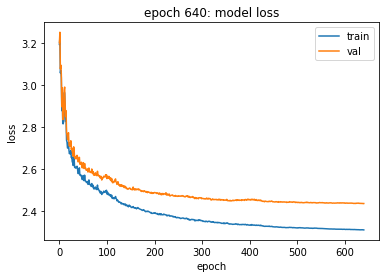

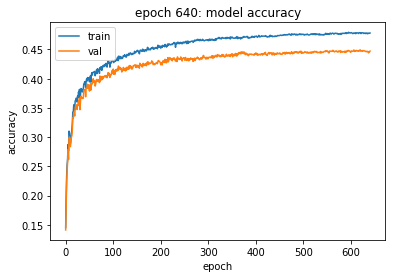



Epoch 641/2000 ...........
Loss train: 2.3092275051235944 
Loss val: 2.435810928725296 
Train accuracy :  0.4786 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 642/2000 ...........
Loss train: 2.309068244452189 
Loss val: 2.4358432641459284 
Train accuracy :  0.47855 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 643/2000 ...........
Loss train: 2.3091110139296767 
Loss val: 2.436313915192244 
Train accuracy :  0.478575 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 644/2000 ...........
Loss train: 2.309393187312856 
Loss val: 2.436304749499793 
Train accuracy :  0.47915 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 645/2000 ...........
Loss train: 2.3090000755131017 
Loss val: 2.435581530243001 
Train accuracy :  0.4791 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 646/2000 ...........
Loss train: 2.3091419346486504 
Loss val: 2.436402168161976 
Train accuracy :  0.4787 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 647/2000 ...........
Loss train: 2.30900739

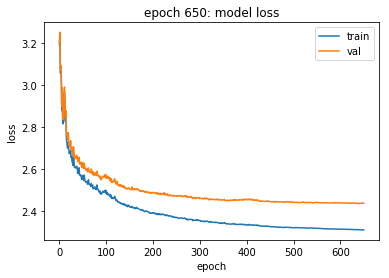

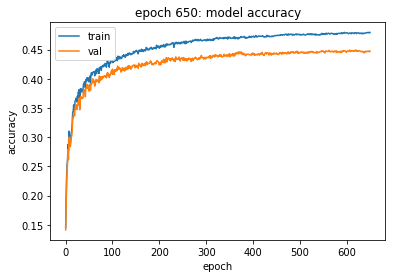



Epoch 651/2000 ...........
Loss train: 2.308935007060935 
Loss val: 2.437740908197148 
Train accuracy :  0.4794 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 652/2000 ...........
Loss train: 2.3091068052173607 
Loss val: 2.4375617527942164 
Train accuracy :  0.4788 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 653/2000 ...........
Loss train: 2.3092274291475436 
Loss val: 2.4374150278727424 
Train accuracy :  0.47925 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 654/2000 ...........
Loss train: 2.308956319607705 
Loss val: 2.4367137700873873 
Train accuracy :  0.479775 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 655/2000 ...........
Loss train: 2.3090452865199556 
Loss val: 2.4377353167317652 
Train accuracy :  0.479625 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 656/2000 ...........
Loss train: 2.3089755866376978 
Loss val: 2.436734472574292 
Train accuracy :  0.479075 
Validation accuracy :  0.4477
Alpha:  0.2


Epoch 657/2000 ...........
Loss train: 2.3

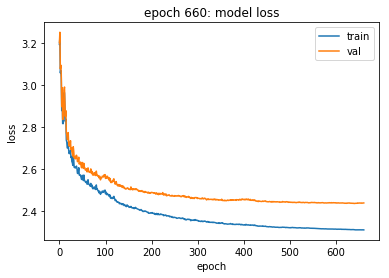

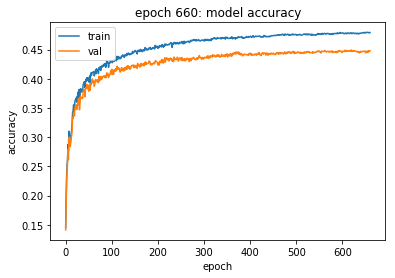



Epoch 661/2000 ...........
Loss train: 2.308938806184774 
Loss val: 2.4376247472762222 
Train accuracy :  0.479075 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 662/2000 ...........
Loss train: 2.3085867255594987 
Loss val: 2.4363828192606385 
Train accuracy :  0.4796 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 663/2000 ...........
Loss train: 2.308652705230133 
Loss val: 2.437014289651642 
Train accuracy :  0.479775 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 664/2000 ...........
Loss train: 2.3082874993884817 
Loss val: 2.4364820572138495 
Train accuracy :  0.480025 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 665/2000 ...........
Loss train: 2.3085266131660656 
Loss val: 2.4365390539525906 
Train accuracy :  0.4785 
Validation accuracy :  0.4441
Alpha:  0.2


Epoch 666/2000 ...........
Loss train: 2.308605050713315 
Loss val: 2.4357005461335746 
Train accuracy :  0.4786 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 667/2000 ...........
Loss train: 2.3

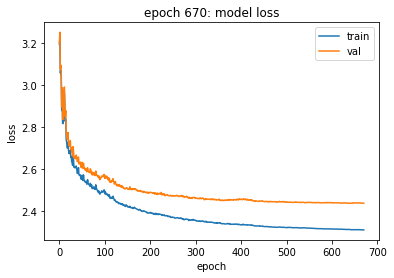

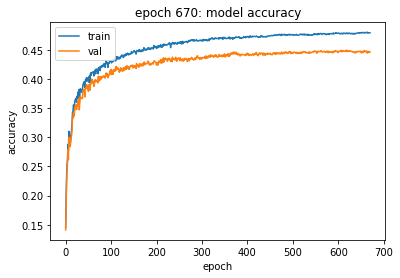



Epoch 671/2000 ...........
Loss train: 2.3081958290094127 
Loss val: 2.4367885761660917 
Train accuracy :  0.478675 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 672/2000 ...........
Loss train: 2.3077330497102757 
Loss val: 2.4363974930538146 
Train accuracy :  0.4797 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 673/2000 ...........
Loss train: 2.308698061626943 
Loss val: 2.436651489026487 
Train accuracy :  0.478575 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 674/2000 ...........
Loss train: 2.3083563214358453 
Loss val: 2.436423756334696 
Train accuracy :  0.4788 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 675/2000 ...........
Loss train: 2.3083929027226833 
Loss val: 2.4363082059078556 
Train accuracy :  0.478925 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 676/2000 ...........
Loss train: 2.308004871197572 
Loss val: 2.435812865107114 
Train accuracy :  0.47845 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 677/2000 ...........
Loss train: 2.30

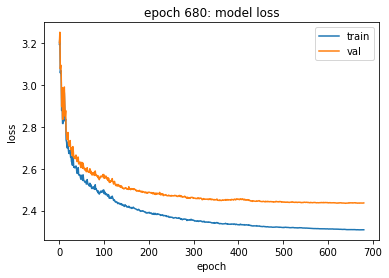

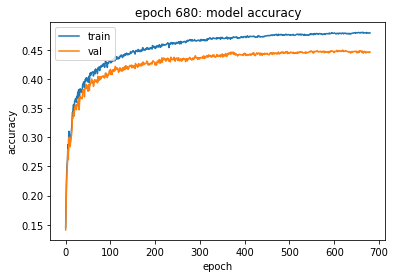



Epoch 681/2000 ...........
Loss train: 2.308267742078829 
Loss val: 2.437583759244454 
Train accuracy :  0.479475 
Validation accuracy :  0.4449
Alpha:  0.2


Epoch 682/2000 ...........
Loss train: 2.308330859439739 
Loss val: 2.437351516704003 
Train accuracy :  0.478875 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 683/2000 ...........
Loss train: 2.307857829741691 
Loss val: 2.4366100590098694 
Train accuracy :  0.4794 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 684/2000 ...........
Loss train: 2.3079750428107926 
Loss val: 2.4370822873426015 
Train accuracy :  0.480225 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 685/2000 ...........
Loss train: 2.3078463522182737 
Loss val: 2.4376046643448532 
Train accuracy :  0.479425 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 686/2000 ...........
Loss train: 2.308052656055322 
Loss val: 2.4379832379015554 
Train accuracy :  0.4801 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 687/2000 ...........
Loss train: 2.3

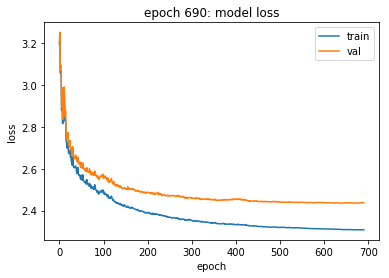

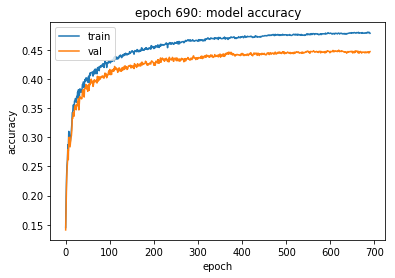



Epoch 691/2000 ...........
Loss train: 2.3085555445096424 
Loss val: 2.4384551732520396 
Train accuracy :  0.4792 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 692/2000 ...........
Loss train: 2.3078047087380225 
Loss val: 2.4380478192041317 
Train accuracy :  0.4798 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 693/2000 ...........
Loss train: 2.307920472446522 
Loss val: 2.437782565615586 
Train accuracy :  0.479675 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 694/2000 ...........
Loss train: 2.308384098364847 
Loss val: 2.4379186508990918 
Train accuracy :  0.47995 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 695/2000 ...........
Loss train: 2.3087386797659946 
Loss val: 2.4373808111080537 
Train accuracy :  0.478375 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 696/2000 ...........
Loss train: 2.308542874382631 
Loss val: 2.436634402246736 
Train accuracy :  0.479375 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 697/2000 ...........
Loss train: 2.30

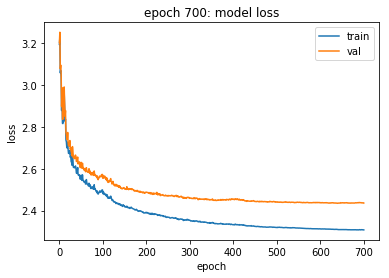

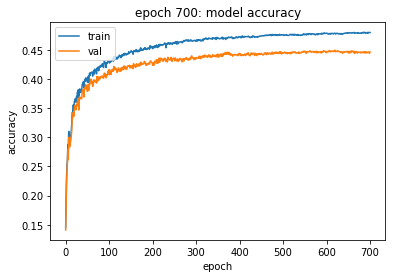



Epoch 701/2000 ...........
Loss train: 2.3074643102933265 
Loss val: 2.4357580098598777 
Train accuracy :  0.479275 
Validation accuracy :  0.4441
Alpha:  0.2


Epoch 702/2000 ...........
Loss train: 2.3075533129445844 
Loss val: 2.4358460684555943 
Train accuracy :  0.480325 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 703/2000 ...........
Loss train: 2.3075559669949 
Loss val: 2.4364008115056235 
Train accuracy :  0.48085 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 704/2000 ...........
Loss train: 2.3076386284226036 
Loss val: 2.4357092924175996 
Train accuracy :  0.47975 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 705/2000 ...........
Loss train: 2.3076323180387095 
Loss val: 2.436065769660826 
Train accuracy :  0.479575 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 706/2000 ...........
Loss train: 2.3072642010383158 
Loss val: 2.4361750103728013 
Train accuracy :  0.48005 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 707/2000 ...........
Loss train: 

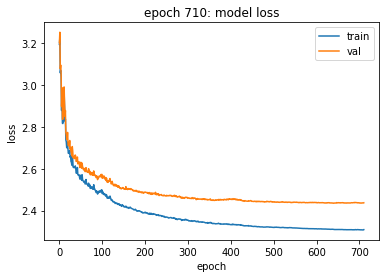

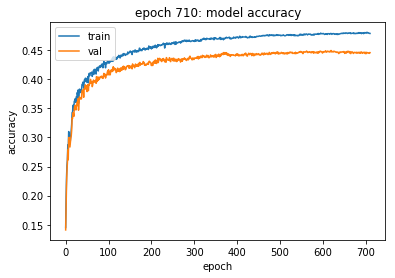



Epoch 711/2000 ...........
Loss train: 2.3080214800396224 
Loss val: 2.4363630507570995 
Train accuracy :  0.479 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 712/2000 ...........
Loss train: 2.30819588660251 
Loss val: 2.4371671173797638 
Train accuracy :  0.478825 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 713/2000 ...........
Loss train: 2.3075714600469794 
Loss val: 2.436357736542129 
Train accuracy :  0.480075 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 714/2000 ...........
Loss train: 2.3075796611918955 
Loss val: 2.4366580898876604 
Train accuracy :  0.478 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 715/2000 ...........
Loss train: 2.3078279430875717 
Loss val: 2.4367680059813424 
Train accuracy :  0.47975 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 716/2000 ...........
Loss train: 2.307522220088554 
Loss val: 2.4368024212130517 
Train accuracy :  0.479625 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 717/2000 ...........
Loss train: 2.307

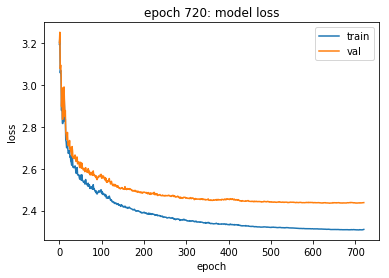

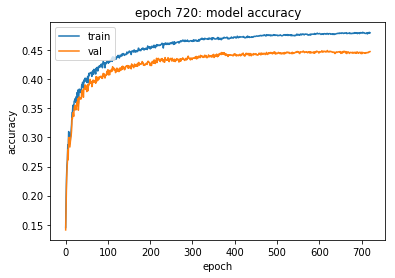



Epoch 721/2000 ...........
Loss train: 2.3097501919282855 
Loss val: 2.43877961369108 
Train accuracy :  0.480525 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 722/2000 ...........
Loss train: 2.3096489825088704 
Loss val: 2.4383600830960583 
Train accuracy :  0.4795 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 723/2000 ...........
Loss train: 2.309171803949922 
Loss val: 2.4382650157335424 
Train accuracy :  0.47985 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 724/2000 ...........
Loss train: 2.3094494080964694 
Loss val: 2.4370797362008343 
Train accuracy :  0.4796 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 725/2000 ...........
Loss train: 2.309603285955123 
Loss val: 2.4385903486670557 
Train accuracy :  0.4797 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 726/2000 ...........
Loss train: 2.3100740090967897 
Loss val: 2.439206738208318 
Train accuracy :  0.48025 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 727/2000 ...........
Loss train: 2.3102

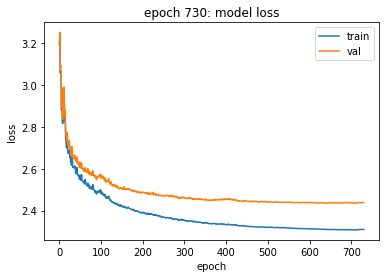

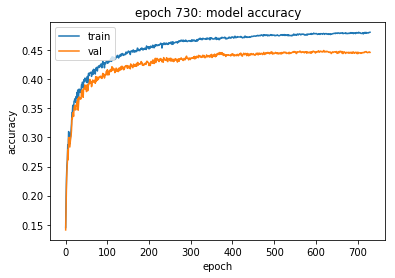



Epoch 731/2000 ...........
Loss train: 2.308053752622596 
Loss val: 2.4366737008288646 
Train accuracy :  0.480825 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 732/2000 ...........
Loss train: 2.3075709844464445 
Loss val: 2.436500500095786 
Train accuracy :  0.480425 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 733/2000 ...........
Loss train: 2.307604973827638 
Loss val: 2.4368338132364644 
Train accuracy :  0.480375 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 734/2000 ...........
Loss train: 2.3074751030647147 
Loss val: 2.436600121466236 
Train accuracy :  0.48045 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 735/2000 ...........
Loss train: 2.3073597048436327 
Loss val: 2.436881173993196 
Train accuracy :  0.479725 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 736/2000 ...........
Loss train: 2.3069828186596713 
Loss val: 2.4356286709830495 
Train accuracy :  0.480825 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 737/2000 ...........
Loss train:

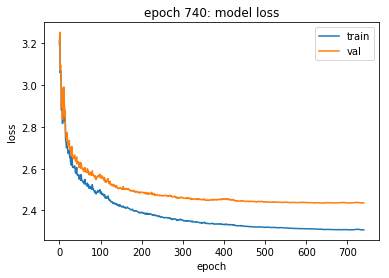

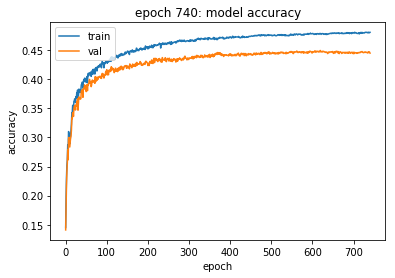



Epoch 741/2000 ...........
Loss train: 2.3069162543592894 
Loss val: 2.436166518494056 
Train accuracy :  0.48075 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 742/2000 ...........
Loss train: 2.30687024956112 
Loss val: 2.43556707176256 
Train accuracy :  0.480875 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 743/2000 ...........
Loss train: 2.3070332871001478 
Loss val: 2.4355628417921946 
Train accuracy :  0.47985 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 744/2000 ...........
Loss train: 2.307188249144699 
Loss val: 2.4355425022452937 
Train accuracy :  0.47985 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 745/2000 ...........
Loss train: 2.3072223687859985 
Loss val: 2.435803154696603 
Train accuracy :  0.480675 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 746/2000 ...........
Loss train: 2.307151374613126 
Loss val: 2.4362537342003727 
Train accuracy :  0.480525 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 747/2000 ...........
Loss train: 2.307

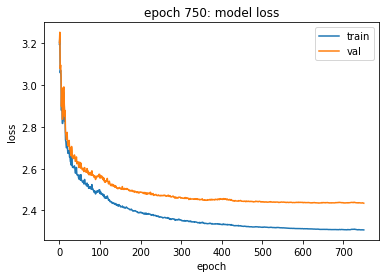

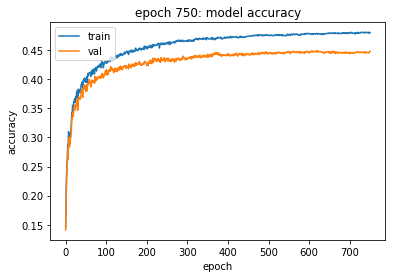



Epoch 751/2000 ...........
Loss train: 2.3061832325431815 
Loss val: 2.434143545634239 
Train accuracy :  0.48065 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 752/2000 ...........
Loss train: 2.3060029630101138 
Loss val: 2.435525067192689 
Train accuracy :  0.481125 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 753/2000 ...........
Loss train: 2.305526835209041 
Loss val: 2.4349827297546236 
Train accuracy :  0.48015 
Validation accuracy :  0.4449
Alpha:  0.2


Epoch 754/2000 ...........
Loss train: 2.3054624859974626 
Loss val: 2.434877998060401 
Train accuracy :  0.480825 
Validation accuracy :  0.4481
Alpha:  0.2


Epoch 755/2000 ...........
Loss train: 2.3054682232619617 
Loss val: 2.4349622333428793 
Train accuracy :  0.4804 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 756/2000 ...........
Loss train: 2.305907995962665 
Loss val: 2.435399400869865 
Train accuracy :  0.481075 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 757/2000 ...........
Loss train: 2.3

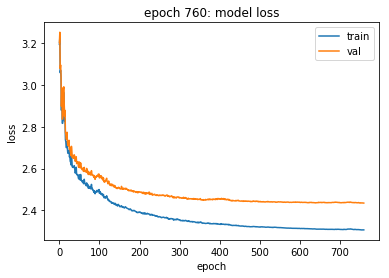

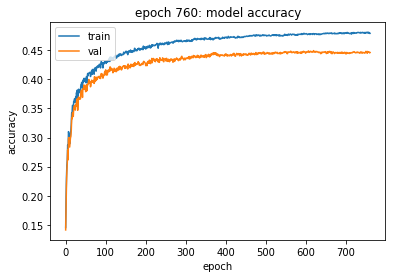



Epoch 761/2000 ...........
Loss train: 2.305443408597906 
Loss val: 2.4347939423514373 
Train accuracy :  0.4802 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 762/2000 ...........
Loss train: 2.3050991431053034 
Loss val: 2.434323019507137 
Train accuracy :  0.4811 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 763/2000 ...........
Loss train: 2.3047686397307996 
Loss val: 2.4343868867747753 
Train accuracy :  0.481675 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 764/2000 ...........
Loss train: 2.304659646369011 
Loss val: 2.4341042170963685 
Train accuracy :  0.480875 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 765/2000 ...........
Loss train: 2.304561267579222 
Loss val: 2.434703684638745 
Train accuracy :  0.4821 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 766/2000 ...........
Loss train: 2.304241390637736 
Loss val: 2.4351100536409374 
Train accuracy :  0.4813 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 767/2000 ...........
Loss train: 2.304375

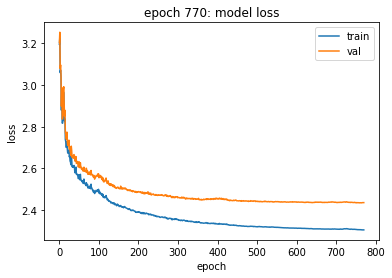

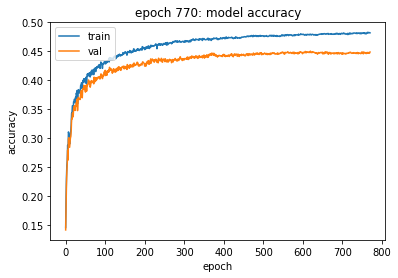



Epoch 771/2000 ...........
Loss train: 2.3041074342058017 
Loss val: 2.435301328058108 
Train accuracy :  0.48165 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 772/2000 ...........
Loss train: 2.304281566062126 
Loss val: 2.434880273437182 
Train accuracy :  0.4818 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 773/2000 ...........
Loss train: 2.303981229878493 
Loss val: 2.4343694686490247 
Train accuracy :  0.482025 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 774/2000 ...........
Loss train: 2.3045440407599957 
Loss val: 2.434523363111479 
Train accuracy :  0.48155 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 775/2000 ...........
Loss train: 2.3041207638715986 
Loss val: 2.4341135231875874 
Train accuracy :  0.481925 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 776/2000 ...........
Loss train: 2.3042224624202716 
Loss val: 2.433627018803561 
Train accuracy :  0.4816 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 777/2000 ...........
Loss train: 2.304

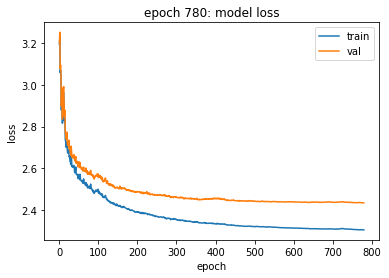

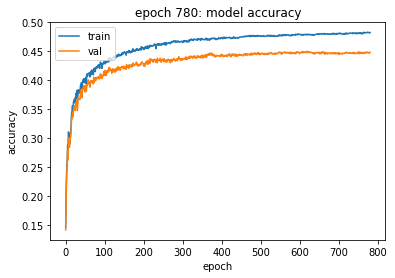



Epoch 781/2000 ...........
Loss train: 2.3036388988346896 
Loss val: 2.4336824989898322 
Train accuracy :  0.48185 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 782/2000 ...........
Loss train: 2.3037135515075926 
Loss val: 2.433913994704643 
Train accuracy :  0.4814 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 783/2000 ...........
Loss train: 2.3035704425068366 
Loss val: 2.4342008592767685 
Train accuracy :  0.481475 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 784/2000 ...........
Loss train: 2.3036940452462082 
Loss val: 2.4337613570795047 
Train accuracy :  0.480325 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 785/2000 ...........
Loss train: 2.3036397656060994 
Loss val: 2.4341294287351887 
Train accuracy :  0.48065 
Validation accuracy :  0.4478
Alpha:  0.2


Epoch 786/2000 ...........
Loss train: 2.3038249322206195 
Loss val: 2.4343391640508316 
Train accuracy :  0.481175 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 787/2000 ...........
Loss train:

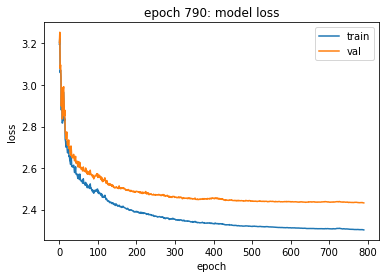

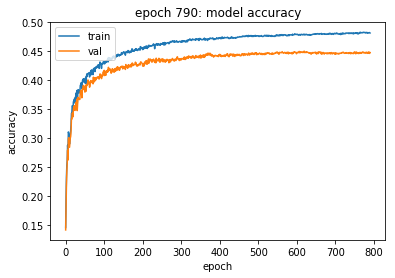



Epoch 791/2000 ...........
Loss train: 2.3020196602803806 
Loss val: 2.4329561349712296 
Train accuracy :  0.480975 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 792/2000 ...........
Loss train: 2.3023862160965907 
Loss val: 2.433034046387313 
Train accuracy :  0.480625 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 793/2000 ...........
Loss train: 2.30237823979346 
Loss val: 2.4333326361231014 
Train accuracy :  0.48015 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 794/2000 ...........
Loss train: 2.302360902719755 
Loss val: 2.4329891144344216 
Train accuracy :  0.480925 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 795/2000 ...........
Loss train: 2.3023472332652535 
Loss val: 2.4340827847092177 
Train accuracy :  0.481125 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 796/2000 ...........
Loss train: 2.3023339719868274 
Loss val: 2.433130901363879 
Train accuracy :  0.4805 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 797/2000 ...........
Loss train: 2

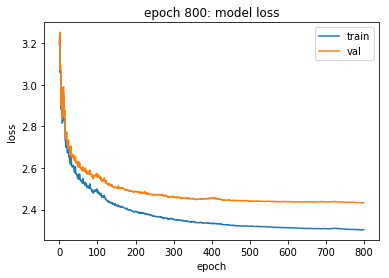

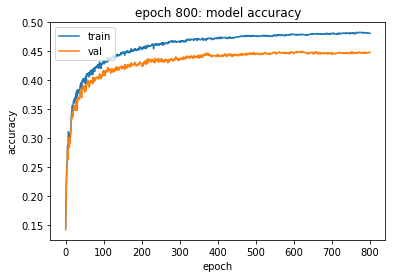



Epoch 801/2000 ...........
Loss train: 2.3030965508421803 
Loss val: 2.4323800961240494 
Train accuracy :  0.478475 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 802/2000 ...........
Loss train: 2.302782983381742 
Loss val: 2.4327037234171245 
Train accuracy :  0.479775 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 803/2000 ...........
Loss train: 2.302608028800423 
Loss val: 2.433432399938778 
Train accuracy :  0.47935 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 804/2000 ...........
Loss train: 2.3020971547091773 
Loss val: 2.4322792701310267 
Train accuracy :  0.4809 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 805/2000 ...........
Loss train: 2.301988363029735 
Loss val: 2.4333331020421216 
Train accuracy :  0.48035 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 806/2000 ...........
Loss train: 2.30190182181204 
Loss val: 2.4318470380536694 
Train accuracy :  0.4813 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 807/2000 ...........
Loss train: 2.301

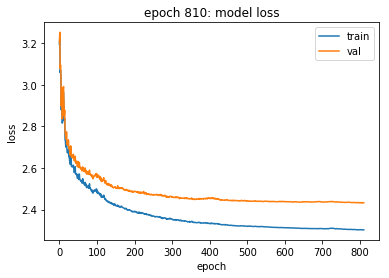

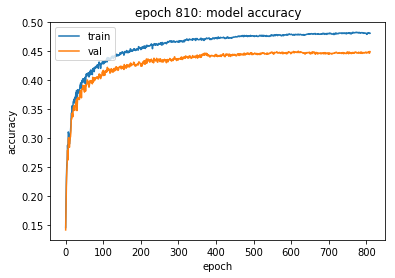



Epoch 811/2000 ...........
Loss train: 2.3019971781591755 
Loss val: 2.4333876940625485 
Train accuracy :  0.481075 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 812/2000 ...........
Loss train: 2.3021725271615985 
Loss val: 2.432845528939939 
Train accuracy :  0.48085 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 813/2000 ...........
Loss train: 2.3025668077999586 
Loss val: 2.4331918900056357 
Train accuracy :  0.48055 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 814/2000 ...........
Loss train: 2.3023971976373243 
Loss val: 2.431943088192065 
Train accuracy :  0.479975 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 815/2000 ...........
Loss train: 2.302341831099476 
Loss val: 2.4321914871622026 
Train accuracy :  0.480475 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 816/2000 ...........
Loss train: 2.3023406948974747 
Loss val: 2.4315200740959853 
Train accuracy :  0.480275 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 817/2000 ...........
Loss train

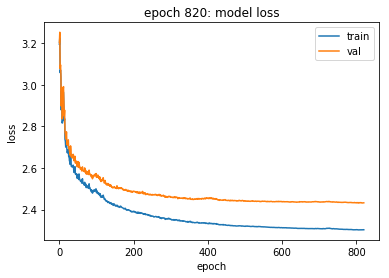

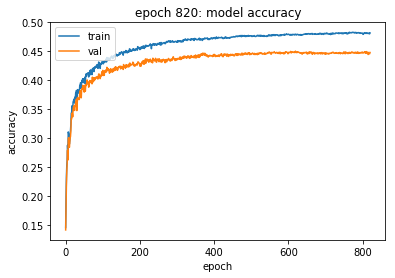



Epoch 821/2000 ...........
Loss train: 2.302430966902437 
Loss val: 2.432939988204955 
Train accuracy :  0.4799 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 822/2000 ...........
Loss train: 2.302212943699321 
Loss val: 2.43286719027477 
Train accuracy :  0.4818 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 823/2000 ...........
Loss train: 2.3029808956569897 
Loss val: 2.4331474342429016 
Train accuracy :  0.480225 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 824/2000 ...........
Loss train: 2.301963537199079 
Loss val: 2.4326684269979064 
Train accuracy :  0.481425 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 825/2000 ...........
Loss train: 2.3017791535593335 
Loss val: 2.432429576248769 
Train accuracy :  0.481575 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 826/2000 ...........
Loss train: 2.301931669869889 
Loss val: 2.4320731094862835 
Train accuracy :  0.4804 
Validation accuracy :  0.4477
Alpha:  0.2


Epoch 827/2000 ...........
Loss train: 2.3014204

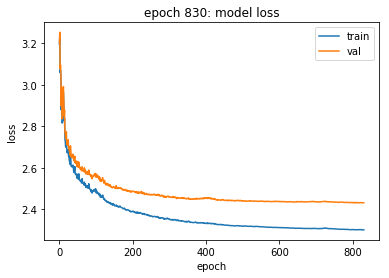

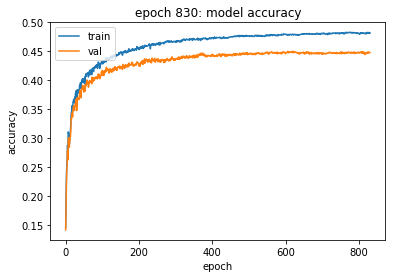



Epoch 831/2000 ...........
Loss train: 2.301754785913255 
Loss val: 2.432323836879155 
Train accuracy :  0.48095 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 832/2000 ...........
Loss train: 2.301802732991654 
Loss val: 2.432013779158249 
Train accuracy :  0.4812 
Validation accuracy :  0.4483
Alpha:  0.2


Epoch 833/2000 ...........
Loss train: 2.302056097820667 
Loss val: 2.4332528176177797 
Train accuracy :  0.48145 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 834/2000 ...........
Loss train: 2.301837047124365 
Loss val: 2.4327784419853242 
Train accuracy :  0.4808 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 835/2000 ...........
Loss train: 2.301577424436747 
Loss val: 2.4326119912377275 
Train accuracy :  0.4818 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 836/2000 ...........
Loss train: 2.3010884409403625 
Loss val: 2.4322849035296037 
Train accuracy :  0.48265 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 837/2000 ...........
Loss train: 2.3016823

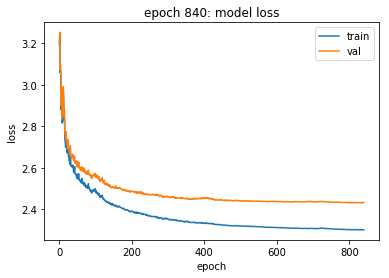

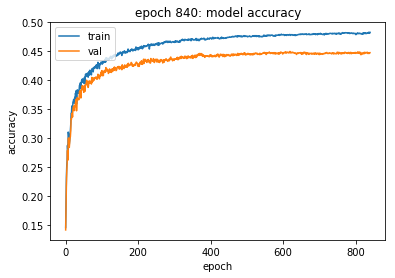



Epoch 841/2000 ...........
Loss train: 2.301593983242648 
Loss val: 2.432200233103783 
Train accuracy :  0.482325 
Validation accuracy :  0.4477
Alpha:  0.2


Epoch 842/2000 ...........
Loss train: 2.3017077292073034 
Loss val: 2.4328038173499613 
Train accuracy :  0.48235 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 843/2000 ...........
Loss train: 2.3014389982254455 
Loss val: 2.4321937142507926 
Train accuracy :  0.482475 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 844/2000 ...........
Loss train: 2.3013534921046332 
Loss val: 2.4322068725812596 
Train accuracy :  0.4824 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 845/2000 ...........
Loss train: 2.301198222703136 
Loss val: 2.4317849879956737 
Train accuracy :  0.482275 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 846/2000 ...........
Loss train: 2.300831062862221 
Loss val: 2.4309827719744352 
Train accuracy :  0.482725 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 847/2000 ...........
Loss train: 

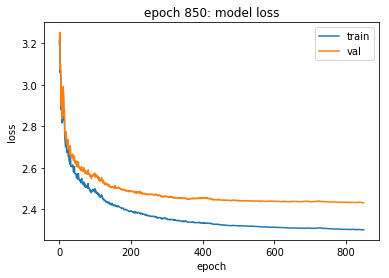

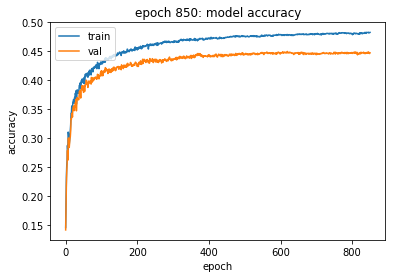



Epoch 851/2000 ...........
Loss train: 2.299868541135171 
Loss val: 2.4310930378824467 
Train accuracy :  0.481875 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 852/2000 ...........
Loss train: 2.2998632789627105 
Loss val: 2.431409121034427 
Train accuracy :  0.482125 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 853/2000 ...........
Loss train: 2.299787934355107 
Loss val: 2.4307696201968834 
Train accuracy :  0.482125 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 854/2000 ...........
Loss train: 2.2997560295022788 
Loss val: 2.4314723840755765 
Train accuracy :  0.482275 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 855/2000 ...........
Loss train: 2.3000713351057374 
Loss val: 2.4308396954983693 
Train accuracy :  0.4821 
Validation accuracy :  0.4482
Alpha:  0.2


Epoch 856/2000 ...........
Loss train: 2.300480362478814 
Loss val: 2.4308703369091798 
Train accuracy :  0.481125 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 857/2000 ...........
Loss train:

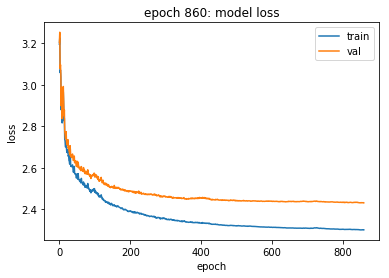

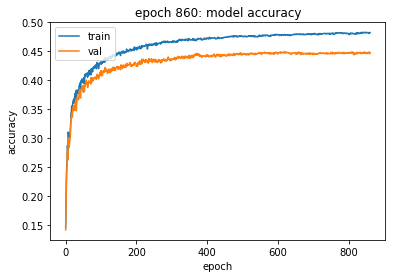



Epoch 861/2000 ...........
Loss train: 2.2998662305258875 
Loss val: 2.430773751270171 
Train accuracy :  0.48165 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 862/2000 ...........
Loss train: 2.2999246124410213 
Loss val: 2.431117422355611 
Train accuracy :  0.48175 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 863/2000 ...........
Loss train: 2.299618626692731 
Loss val: 2.4312677851687665 
Train accuracy :  0.48195 
Validation accuracy :  0.4478
Alpha:  0.2


Epoch 864/2000 ...........
Loss train: 2.2996680306269512 
Loss val: 2.4319583126375983 
Train accuracy :  0.4815 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 865/2000 ...........
Loss train: 2.299345062303233 
Loss val: 2.43134994465024 
Train accuracy :  0.48205 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 866/2000 ...........
Loss train: 2.299252522109379 
Loss val: 2.431223587024434 
Train accuracy :  0.48235 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 867/2000 ...........
Loss train: 2.2990128

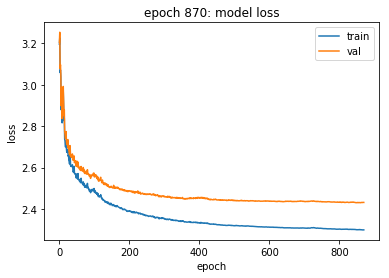

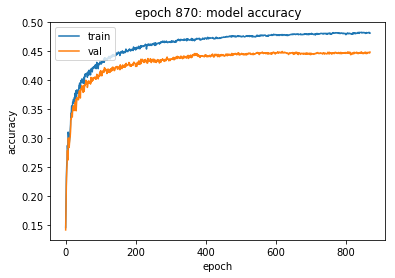



Epoch 871/2000 ...........
Loss train: 2.2990361698962576 
Loss val: 2.431412802203909 
Train accuracy :  0.481125 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 872/2000 ...........
Loss train: 2.29919150277581 
Loss val: 2.432055110225854 
Train accuracy :  0.481575 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 873/2000 ...........
Loss train: 2.299677625176587 
Loss val: 2.432008730016369 
Train accuracy :  0.480875 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 874/2000 ...........
Loss train: 2.2995078580589428 
Loss val: 2.431513364486874 
Train accuracy :  0.481175 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 875/2000 ...........
Loss train: 2.29963179450171 
Loss val: 2.4324866398460503 
Train accuracy :  0.481125 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 876/2000 ...........
Loss train: 2.2996194354374815 
Loss val: 2.431726484848022 
Train accuracy :  0.481375 
Validation accuracy :  0.4489
Alpha:  0.2


Epoch 877/2000 ...........
Loss train: 2.2

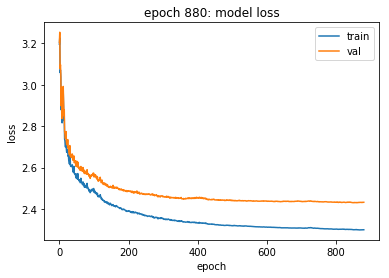

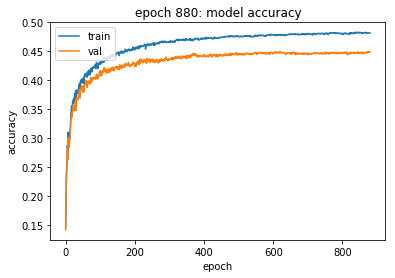



Epoch 881/2000 ...........
Loss train: 2.2996107953934963 
Loss val: 2.432326538411113 
Train accuracy :  0.48145 
Validation accuracy :  0.4477
Alpha:  0.2


Epoch 882/2000 ...........
Loss train: 2.299646962442058 
Loss val: 2.4326401209629194 
Train accuracy :  0.4817 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 883/2000 ...........
Loss train: 2.2994351386484904 
Loss val: 2.4320607899097118 
Train accuracy :  0.481275 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 884/2000 ...........
Loss train: 2.2991060757635946 
Loss val: 2.432318386957794 
Train accuracy :  0.4817 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 885/2000 ...........
Loss train: 2.2992331826463865 
Loss val: 2.4316973362298855 
Train accuracy :  0.4814 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 886/2000 ...........
Loss train: 2.29926463266222 
Loss val: 2.43225835006581 
Train accuracy :  0.48155 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 887/2000 ...........
Loss train: 2.299268

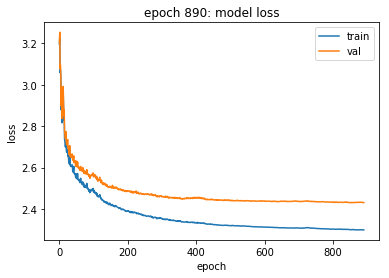

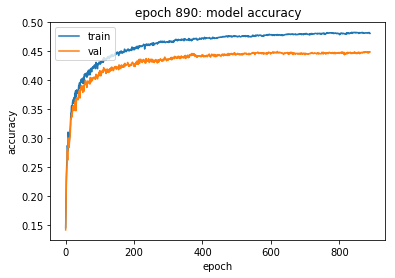



Epoch 891/2000 ...........
Loss train: 2.2990188540413627 
Loss val: 2.4312489841792377 
Train accuracy :  0.4816 
Validation accuracy :  0.4483
Alpha:  0.2


Epoch 892/2000 ...........
Loss train: 2.2994717689058843 
Loss val: 2.431128912066178 
Train accuracy :  0.48145 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 893/2000 ...........
Loss train: 2.299414830373423 
Loss val: 2.430704402589283 
Train accuracy :  0.481825 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 894/2000 ...........
Loss train: 2.2992499840770395 
Loss val: 2.4303760576741467 
Train accuracy :  0.481375 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 895/2000 ...........
Loss train: 2.2989978012347105 
Loss val: 2.4311065748916625 
Train accuracy :  0.481275 
Validation accuracy :  0.4487
Alpha:  0.2


Epoch 896/2000 ...........
Loss train: 2.2991826028752547 
Loss val: 2.431696609005908 
Train accuracy :  0.4812 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 897/2000 ...........
Loss train: 2.2994

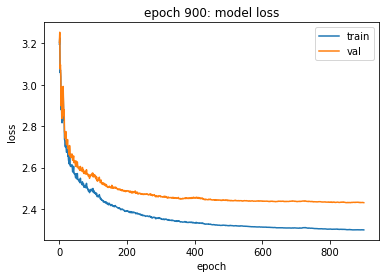

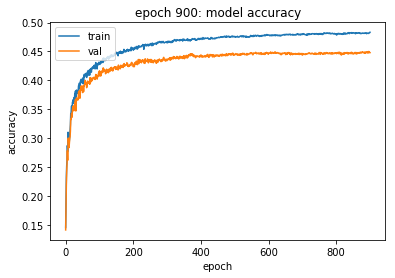



Epoch 901/2000 ...........
Loss train: 2.2986857789159183 
Loss val: 2.4305955591068416 
Train accuracy :  0.48185 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 902/2000 ...........
Loss train: 2.2986719089000944 
Loss val: 2.4308098113872174 
Train accuracy :  0.482325 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 903/2000 ...........
Loss train: 2.298326951710259 
Loss val: 2.4302459520617443 
Train accuracy :  0.482725 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 904/2000 ...........
Loss train: 2.2981823518637325 
Loss val: 2.4293782149359933 
Train accuracy :  0.482175 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 905/2000 ...........
Loss train: 2.298112013991982 
Loss val: 2.429792066096425 
Train accuracy :  0.48225 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 906/2000 ...........
Loss train: 2.2982018797480226 
Loss val: 2.429495636714854 
Train accuracy :  0.48155 
Validation accuracy :  0.4482
Alpha:  0.2


Epoch 907/2000 ...........
Loss train: 

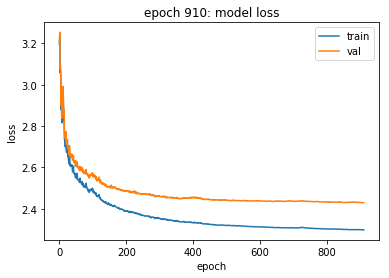

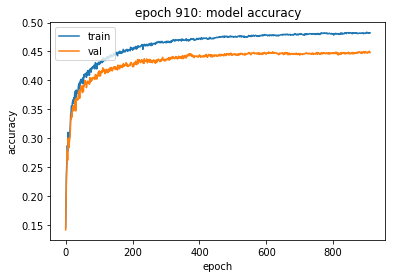



Epoch 911/2000 ...........
Loss train: 2.297868111681858 
Loss val: 2.430500717285451 
Train accuracy :  0.482475 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 912/2000 ...........
Loss train: 2.2977773638063135 
Loss val: 2.430464332485048 
Train accuracy :  0.4821 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 913/2000 ...........
Loss train: 2.297955307255131 
Loss val: 2.4308421497833717 
Train accuracy :  0.48185 
Validation accuracy :  0.4485
Alpha:  0.2


Epoch 914/2000 ...........

KeyboardInterrupt: 

In [293]:
batch_size = 1000
dropout_prob = 0.5
num_epochs = 2000
alpha = 4
#np.random.seed(0)
history_loss_train,history_loss_val, history_acc_train, history_acc_val = [],[],[],[]
num_train_samples = x_train.shape[0]
num_batches = num_train_samples // batch_size
layers_size = [3072, 128, 64, 10]
thetas = np.asarray([np.random.randn(layers_size[i], layers_size[i+1]) for i in range(0, len(layers_size)-1)])
y_pred = forward(thetas, x_train,dropout_prob, False)
loss_val = loss(y_train, y_pred[-1])
print("Initial loss :", loss_val)
Et = np.asarray([np.zeros(th.shape) for th in thetas])
for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('\n\nEpoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no + 1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, thetas,dropout_prob)
        
        for j in range(0,len(d_theta)):
            Et[j] = RMSprob(Et[j], d_theta[j], 0.9, alpha, 1)
            #thetas[j] =thetas[j] - alpha*d_theta[j] #Обычный mini-batch BackProp
            thetas[j] =thetas[j] - Et[j] 
  
    #loss train
    pred_train_probs = forward(thetas, x_train,dropout_prob, False)
    y_train_out = pred_train_probs[-1]
    loss_train = loss(y_train,  y_train_out)
    history_loss_train.append(loss_train)
    
    #loss val
    pred_val_probs = forward(thetas, x_val,dropout_prob, False)
    y_val_out = pred_val_probs[-1]
    loss_val = loss(y_val, y_val_out)
    history_loss_val.append(loss_val)
    
    history_acc_train.append(acc(y_train, y_train_out))
    history_acc_val.append(acc(y_val, y_val_out))
    print("\nLoss train:", loss_train,
          "\nLoss val:", loss_val,
          "\nTrain accuracy : ",acc(y_train, y_train_out),
          "\nValidation accuracy : ", acc(y_val, y_val_out))
    print("Alpha: ", alpha)
    alpha = max(0.2, alpha * 0.995)#изменение шага градиента (сначала идем большими, постепенно уменьшая)
    if (np.mod(i, num_epochs // (num_epochs/10)) == 0) and i != 0:#каждые 10 выводим на экран
        plt.plot(history_loss_train)
        plt.plot(history_loss_val)
        plt.title(f'epoch {i}: model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

        plt.plot(history_acc_train)
        plt.plot(history_acc_val)
        plt.title(f'epoch {i}: model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


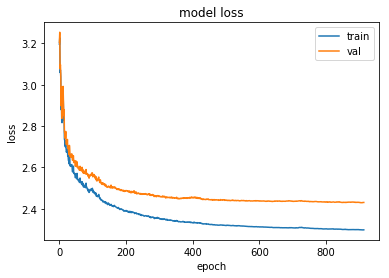

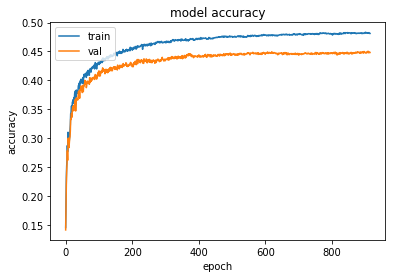

In [294]:
plt.plot(history_loss_train)
plt.plot(history_loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history_acc_train)
plt.plot(history_acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [295]:
pred_test_probs = forward(thetas, x_test,dropout_prob, False)
y_test_out = pred_test_probs[-1]
loss_test = loss(y_test, y_test_out)
print("\nLoss test:", loss_test,
          "\nTest accuracy : ",acc(y_test, y_test_out))


Loss test: 2.384499088102048 
Test accuracy :  0.4554


In [296]:
import pickle
pickle.dump(thetas, open('weights\\thetasTwoHidLay128-64_RSMprob_880epochs.pkl', 'wb'))

In [254]:
f = open('results_Kozyrevskii5710M.txt','w')
for y in y_test_out:
    f.write(str(np.argmax(y))+'\n')
f.close()